In [1]:
#Import Data and necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform

import warnings

warnings.simplefilter(action = "ignore", category = FutureWarning) 

### Business Problem:
Rossmann drug stores has asked to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams!

Historical sales data for 1,115 Rossmann stores is provided. The task is to forecast the "Sales" column for the test set. 
Note that some stores in the dataset were temporarily closed for refurbishment. 

### Files
train.csv - historical data including Sales

test.csv - historical data excluding Sales

sample_submission.csv - a sample submission file in the correct format

store.csv - supplemental information about the stores

### Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [3]:
#Load data from csv files

base_path = "/Users/sanchijain/Desktop/Data_Analytics_Science/MSDS_Colorado/DTSA-5509_Intro_to_ML_Supervised_Learning/DTSA-5509_Final_Project/rossmann-store-sales_data"

#Using os.path.join() (cross-platform safe)
train_path = os.path.join(base_path, "train.csv")
store_path = os.path.join(base_path, "store.csv")
test_path = os.path.join(base_path, "test.csv")

#Loading train csv, 'StateHoliday' column has str and int dtype so low_memory is set to False
train = pd.read_csv(train_path, low_memory = False)
print("train dataset")
print(train.head())

#Loading store csv
store = pd.read_csv(store_path)
print("store dataset")
print(store.head())

#Loading test csv
test = pd.read_csv(test_path)
print("test dataset")
print(test.head())

train dataset
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
store dataset
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0         

In [4]:
print(train.info())
print(store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   A

In [5]:
#Check for the missing values
print("Number of missing values in each column of store dataset")

for col in store.columns:
    print(col, ":", store[col].isna().sum())

Number of missing values in each column of store dataset
Store : 0
StoreType : 0
Assortment : 0
CompetitionDistance : 3
CompetitionOpenSinceMonth : 354
CompetitionOpenSinceYear : 354
Promo2 : 0
Promo2SinceWeek : 544
Promo2SinceYear : 544
PromoInterval : 544


In [6]:
#Merging train and store df on 'store' column
store_df = pd.merge(train, store, how = "left", on = "Store")
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Inspecting the dataset

In [16]:
store_df.shape

#1.01 million records and 18 features in the dataset

(1017209, 18)

In [18]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [20]:
store_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [21]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [24]:
#Make all column headers to lower case and making all names to snake case from camel case
import re
store_df.columns = [re.sub(r'(?<!^)(?=[A-Z])','_', col).lower() for col in store_df.columns]

print(store_df.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


In [26]:
#Converting 'date' column from object to date datatype
store_df['date']= pd.to_datetime(store_df['date'])

In [28]:
#Segregating month and year from 'date' into separate columns
store_df['month'] = store_df['date'].dt.month
store_df['year'] = store_df['date'].dt.year

### Check for unique values

In [31]:
#Number of unique values in each column of the df
print("Number of unique values in each column")
for col in store_df.columns:
    print(col, ":", store_df[col].nunique())

Number of unique values in each column
store : 1115
day_of_week : 7
date : 942
sales : 21734
customers : 4086
open : 2
promo : 2
state_holiday : 4
school_holiday : 2
store_type : 4
assortment : 3
competition_distance : 654
competition_open_since_month : 12
competition_open_since_year : 23
promo2 : 2
promo2_since_week : 24
promo2_since_year : 7
promo_interval : 3
month : 12
year : 3


In [33]:
#Unique values in each of the categorical features
unique_val_col_list = ['day_of_week', 'open', 'promo','state_holiday', 'school_holiday', 'store_type', 'assortment', 
                       'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
                       'promo2_since_year', 'promo_interval', 'month', 'year']

print("Unique values for each categorical column")
for col in unique_val_col_list:
    print(col, ":", store_df[col].unique())

Unique values for each categorical column
day_of_week : [5 4 3 2 1 7 6]
open : [1 0]
promo : [1 0]
state_holiday : ['0' 'a' 'b' 'c']
school_holiday : [1 0]
store_type : ['c' 'a' 'd' 'b']
assortment : ['a' 'c' 'b']
competition_open_since_month : [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
competition_open_since_year : [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
promo2 : [0 1]
promo2_since_week : [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
promo2_since_year : [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
promo_interval : [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
month : [ 7  6  5  4  3  2  1 12 11 10  9  8]
year : [2015 2014 2013]


### Check for Missing Values

In [36]:
#Check for the missing values
print("Number of missing values in each column")

for col in store_df.columns:
    print(col, ":", store_df[col].isna().sum())

Number of missing values in each column
store : 0
day_of_week : 0
date : 0
sales : 0
customers : 0
open : 0
promo : 0
state_holiday : 0
school_holiday : 0
store_type : 0
assortment : 0
competition_distance : 2642
competition_open_since_month : 323348
competition_open_since_year : 323348
promo2 : 0
promo2_since_week : 508031
promo2_since_year : 508031
promo_interval : 508031
month : 0
year : 0


In [38]:
#Filter all rows where 'competition_distance' has missing values
store_df[store_df['competition_distance'].isna()]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month,year
290,291,5,2015-07-31,10052,973,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,7,2015
621,622,5,2015-07-31,6306,540,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN,7,2015
878,879,5,2015-07-31,6000,466,1,1,0,0,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",7,2015
1405,291,4,2015-07-30,9030,883,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,7,2015
1736,622,4,2015-07-30,5412,406,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015601,622,3,2013-01-02,4080,451,1,0,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN,1,2013
1015858,879,3,2013-01-02,3077,326,1,0,0,1,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",1,2013
1016385,291,2,2013-01-01,0,0,0,0,a,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,1,2013
1016716,622,2,2013-01-01,0,0,0,0,a,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN,1,2013


In [40]:
#All the unique values of 'store', 'store_type', 'assortment' where 'competition_distance' is missing
competition_missing_rows = store_df[store_df['competition_distance'].isna()]

print("Unique Stores:", competition_missing_rows['store'].unique())
print("Unique Store_type:", competition_missing_rows['store_type'].unique())
print("Unique assortment:", competition_missing_rows['assortment'].unique())

Unique Stores: [291 622 879]
Unique Store_type: ['d' 'a']
Unique assortment: ['a' 'c']


In [42]:
#There are 3 stores (291, 622, 879) Stores with missing competition distance that means there's no competitor store closeby of these stores.
#Lets replace the 'competition_distance' missing values with a large value (as competitor may be located far)

#Define a large value to indicate 'no nearby competition'
large_distance = store_df['competition_distance'].max() + 1000

#Apply conditional update only to rows with missing competition_distance
store_df.loc[store_df['competition_distance'].isna(), 'competition_distance'] = large_distance

In [44]:
#Viewing competition_open_since_month's missing values

store_df[store_df['competition_open_since_month'].isna()]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month,year
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov",7,2015
15,16,5,2015-07-31,10231,979,1,1,0,1,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN,7,2015
18,19,5,2015-07-31,8234,718,1,1,0,1,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec",7,2015
21,22,5,2015-07-31,6566,633,1,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017189,1096,2,2013-01-01,0,0,0,0,a,1,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec",1,2013
1017193,1100,2,2013-01-01,0,0,0,0,a,1,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,2013
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,2013
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,1,2013


In [48]:
#Replacing missing values in 'competition_open_since_month' and 'competition_open_since_year' with latest date in the data frame
#As for cases where there is no competition around them there won't be any meaning of the open date so having the latest date will provide
#no historical impact. And for cases, where the opening date is not available we are just filling the missing values with the latest date.

#Finding the max date in the dataframe
latest_date = store_df['date'].max()

print("latest date:", latest_date)

latest date: 2015-07-31 00:00:00


In [50]:
#Replace missing values with latest date
store_df['competition_open_since_month'].fillna(latest_date.month, inplace = True)
store_df['competition_open_since_year'].fillna(latest_date.year, inplace = True)

store_df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
month                                0
year                                 0
dtype: int64

In [52]:
#Converting the columns to int datatype
store_df['competition_open_since_month'] = store_df['competition_open_since_month'].astype(int)
store_df['competition_open_since_year'] = store_df['competition_open_since_year'].astype(int)

store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [54]:
store_df[store_df['promo2_since_week'].isna()]['promo2'].unique()
#This gives us the rows where promo2_since_week info is missing, the corresponding unique value of promo2 in those rows is 0 i.e. no promo. 
#Let's see wherever the value of promo2 is 0, the corresponding promo2_since_week is missing or no.

array([0])

In [56]:
#Number of rows with missing 'promo2_since_week' values- 508,031
store_df['promo2_since_week'].isna().sum()

508031

In [58]:
#So if a store didn't have promo2, then it didn't have promo2_since_week, month and interval. 
#Replacing all the missing values of those columns with corresponding latest date (year from latest_date and week# =1 by default)

store_df['promo2_since_week'].fillna(1, inplace = True)
store_df['promo2_since_year'].fillna(latest_date.year, inplace = True)
store_df['promo_interval'].fillna(0, inplace = True)

In [60]:
#Cleaning promo2_since_week and promo2_since_year column

#Convert to int
store_df['promo2_since_week'] = store_df['promo2_since_week'].astype(int)
store_df['promo2_since_year'] = store_df['promo2_since_year'].astype(int)

In [62]:
store_df.isna().sum()

#Viola!!! We have a dataset with 0 missing values

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month                           0
year                            0
dtype: int64

### Data type check

In [64]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [66]:
#Combine competition_open_since_month and competition_open_since_year and convert to datetime datatype and assume 1st of the month as day

store_df['competition_open_since_date'] = pd.to_datetime(store_df['competition_open_since_year'].astype(str) + '-' +
                                                         store_df['competition_open_since_month'].astype(str) + '-01')



In [68]:
#Drop 'competition_open_since_month' and 'competition_open_since_year' columns
store_df.drop(['competition_open_since_month', 'competition_open_since_year'], axis = 1, inplace = True)

In [72]:
#Convert year + week to a date (Monday of that week)
store_df['promo2_since_date'] = pd.to_datetime(store_df['promo2_since_year'].astype(str) + '-' +
                                               store_df['promo2_since_week'].astype(str) + '-1', #'-1' = Monday 
                                               format = '%Y-%W-%w') #%Y-Year, %W- week number, %w= weekday

In [74]:
#Drop promo2_since_week and year columns
store_df.drop(['promo2_since_week', 'promo2_since_year'], axis = 1, inplace = True)

In [78]:
#Creating new columns: competition_open_since = (date - competition_open_since_date)
#promo2_since = (date - promo2_since_date)
#It will the number of days passed since the competiton opened and promo 2 began

store_df['competition_open_since'] = store_df['date'] - store_df['competition_open_since_date']

store_df['promo2_since'] = store_df['date'] - store_df['promo2_since_date']

store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype          
---  ------                       --------------    -----          
 0   store                        1017209 non-null  int64          
 1   day_of_week                  1017209 non-null  int64          
 2   date                         1017209 non-null  datetime64[ns] 
 3   sales                        1017209 non-null  int64          
 4   customers                    1017209 non-null  int64          
 5   open                         1017209 non-null  int64          
 6   promo                        1017209 non-null  int64          
 7   state_holiday                1017209 non-null  object         
 8   school_holiday               1017209 non-null  int64          
 9   store_type                   1017209 non-null  object         
 10  assortment                   1017209 non-null  object         
 11

In [82]:
#Modifying state_holiday to 'is_holiday' binary feature

#Converting state_holiday to str dtype and then 'is_holiday' to binary
store_df['is_holiday'] = store_df['state_holiday'].astype(str).apply(lambda x:0 if x == '0' else 1)

In [84]:
#Creating 'is_weekend' binary feature from 'day_of_week' column

store_df['is_weekend'] = store_df['day_of_week'].apply(lambda x: 1 if x in [6, 7] else 0)

### Exploratory Data Analysis

In [87]:
# Lets segregate categorical, numerical but categorical and numerical columns:

def col_names(data, cat = 15):
    cat_cols_1 = [col for col in data if data[col].dtype == 'O' or data[col].dtype == 'category']
    num_but_cat = [col for col in data if data[col].dtype not in ['category', 'datetime64[ns]', "O"] and data[col].nunique() < cat]
    cat_cols = cat_cols_1 + num_but_cat

    num_cols = [col for col in data if data[col].dtype not in ['category', 'datetime64[ns]', 'O'] and data[col].nunique() > cat]

    date_cols = [col for col in data if data[col].dtype == 'datetime64[ns]']

    print(f"\nOnly category columns: {cat_cols_1} and length: {len(cat_cols_1)}")
    print("\nNumeric but category columns:", num_but_cat,"and length: ", len(num_but_cat))
    print("\nAll categorical columns:", cat_cols, "and length: ", len(cat_cols))
    print("\nAll numerical columns:", num_cols, "and length: ", len(num_cols))
    print("\nAll date columns:", date_cols, "and length: ", len(date_cols))
    
    return cat_cols_1, num_but_cat, cat_cols, num_cols, date_cols

In [89]:
result = col_names(store_df)
cat_cols_1, num_but_cat, cat_cols, num_cols, date_cols = result[0], result[1], result[2], result[3], result[4]


Only category columns: ['state_holiday', 'store_type', 'assortment', 'promo_interval'] and length: 4

Numeric but category columns: ['day_of_week', 'open', 'promo', 'school_holiday', 'promo2', 'month', 'year', 'is_holiday', 'is_weekend'] and length:  9

All categorical columns: ['state_holiday', 'store_type', 'assortment', 'promo_interval', 'day_of_week', 'open', 'promo', 'school_holiday', 'promo2', 'month', 'year', 'is_holiday', 'is_weekend'] and length:  13

All numerical columns: ['store', 'sales', 'customers', 'competition_distance', 'competition_open_since', 'promo2_since'] and length:  6

All date columns: ['date', 'competition_open_since_date', 'promo2_since_date'] and length:  3


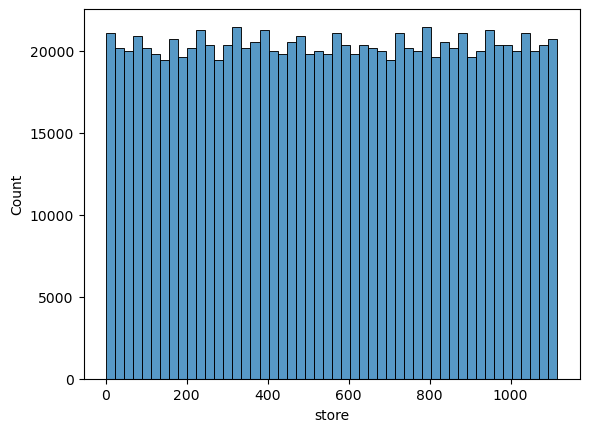

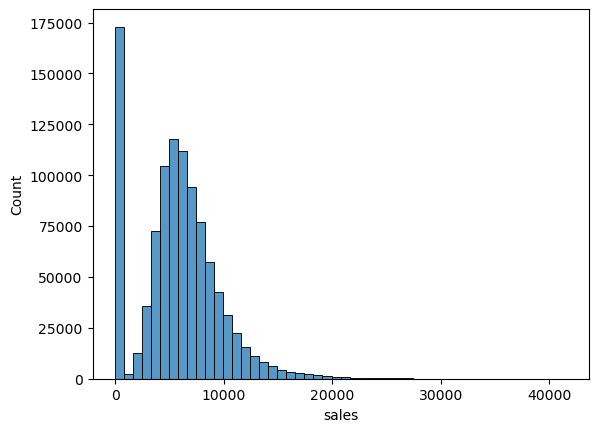

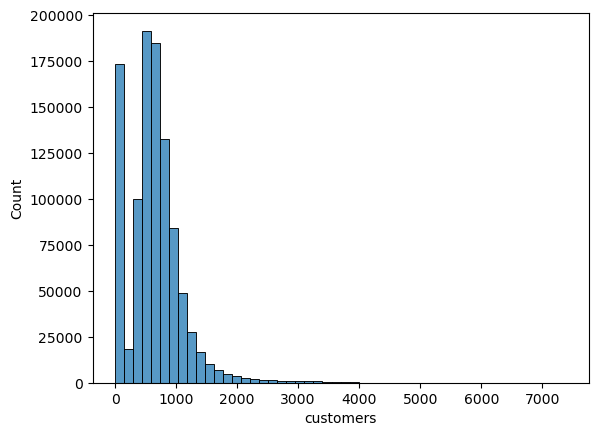

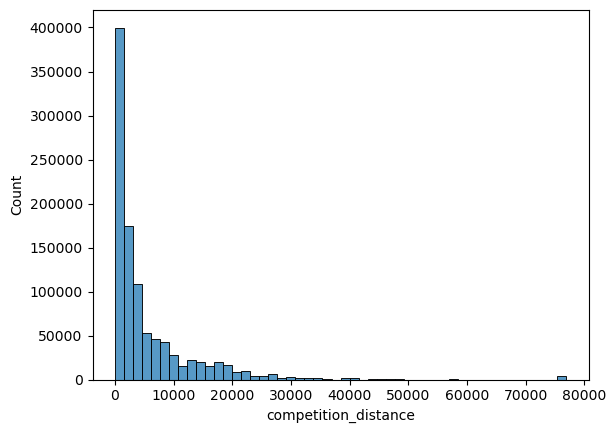

In [91]:
#Let's look at the distributions of numerical columns except 'competition_open_since' and 'promo2_since'

num_cols_list = ['store', 'sales', 'customers', 'competition_distance']

for col in num_cols_list:
    sns.histplot(store_df, x = col, bins = 50, stat = 'count')
    plt.show()

#A lot of points with Sales = 0, let's inspect them further

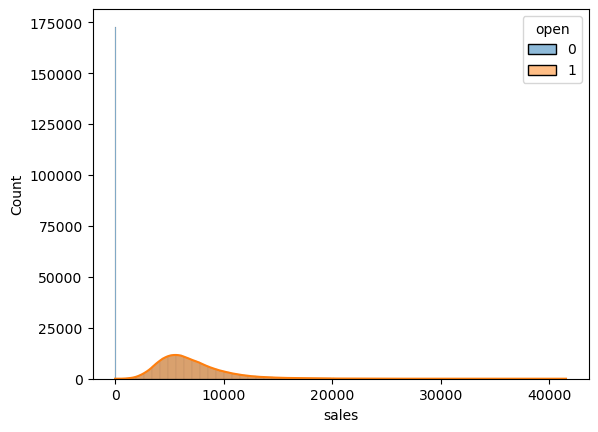

In [93]:
#histogram of sales wrt to store being open
sns.histplot(store_df, x = 'sales', hue = 'open', stat = 'count', kde = True)
plt.show()

In [97]:
#Looking at days where Sales = 0
zero_sales = store_df[store_df['sales'] == 0]

#172871 rows - majorly sales = 0 when open = 0 ie the store was closed, so it is obvious sales will be 0.

In [99]:
zero_sales[zero_sales['open'] == 1].info()
#54 rows where sales = 0 even when the store was open

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 86825 to 999016
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   store                        54 non-null     int64          
 1   day_of_week                  54 non-null     int64          
 2   date                         54 non-null     datetime64[ns] 
 3   sales                        54 non-null     int64          
 4   customers                    54 non-null     int64          
 5   open                         54 non-null     int64          
 6   promo                        54 non-null     int64          
 7   state_holiday                54 non-null     object         
 8   school_holiday               54 non-null     int64          
 9   store_type                   54 non-null     object         
 10  assortment                   54 non-null     object         
 11  competition_distance         54

In [101]:
#Dropping all rows where Sales = 0 and Open = 0, as there won't be any sales if store is closed ie ~172K rows
rows_to_drop = store_df[store_df['open'] == 0].index

#Drop the rows
store_df = store_df.drop(index = rows_to_drop)

#Reset index
store_df = store_df.reset_index(drop = True)

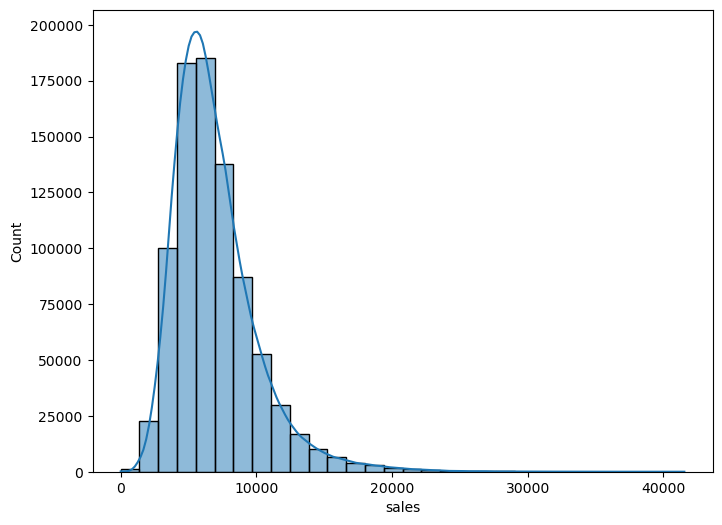

In [103]:
#histogram of sales wrt to store being open
plt.figure(figsize = (8,6))
sns.histplot(store_df, x = 'sales', bins = 30 , stat = 'count', kde = True)
plt.show()

<Axes: >

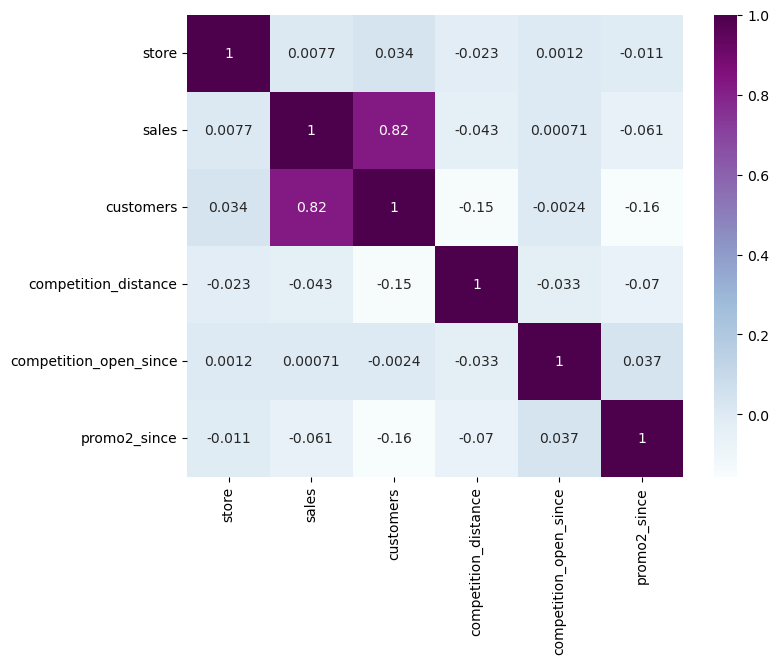

In [105]:
#Heatmap to see correlation of all numerical variables 
plt.figure(figsize = (8,6))
sns.heatmap(store_df[num_cols].corr(), annot = True, cmap = "BuPu")

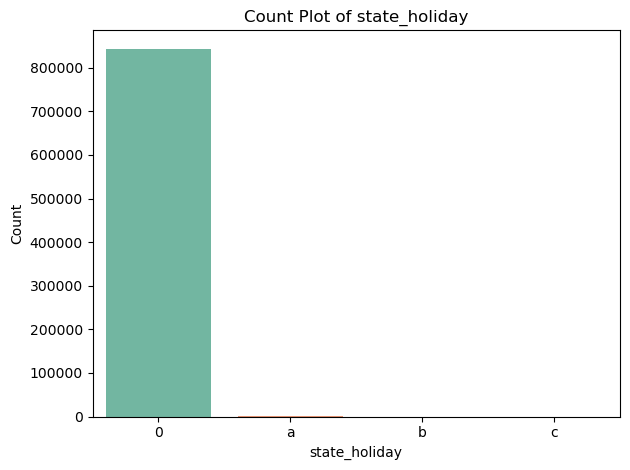

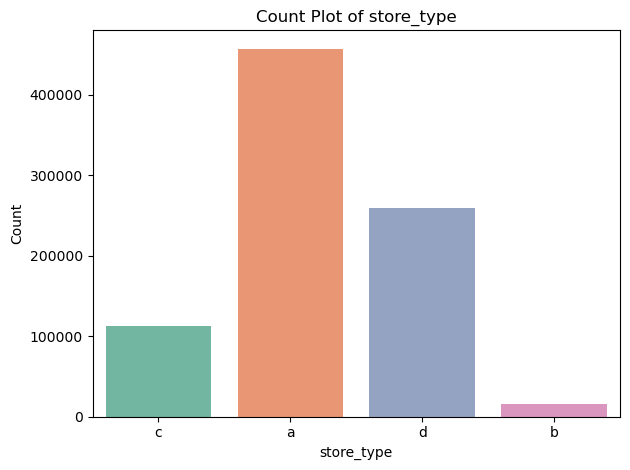

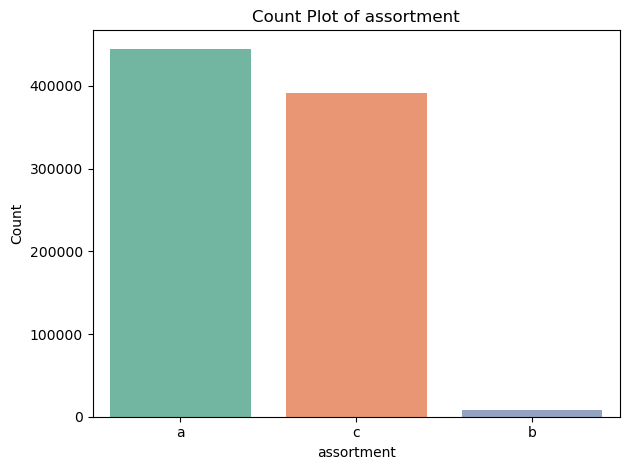

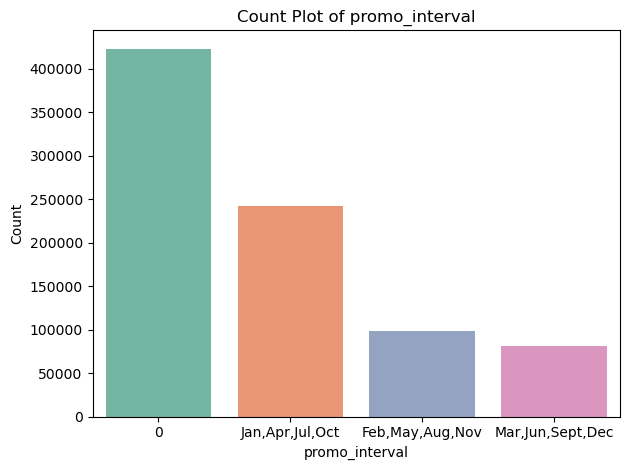

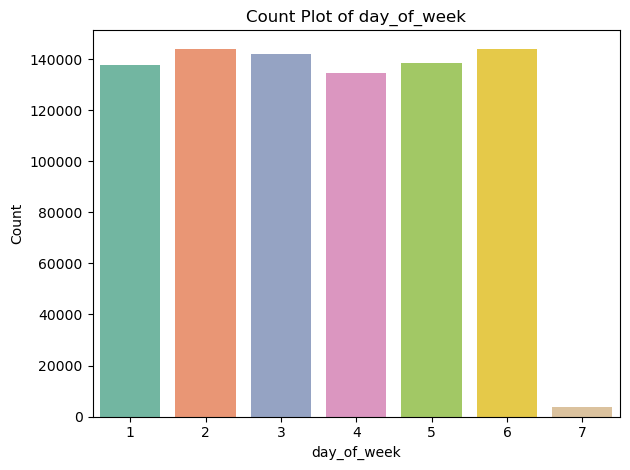

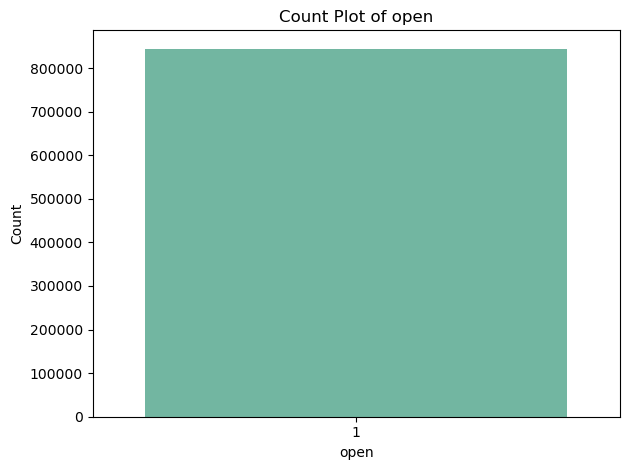

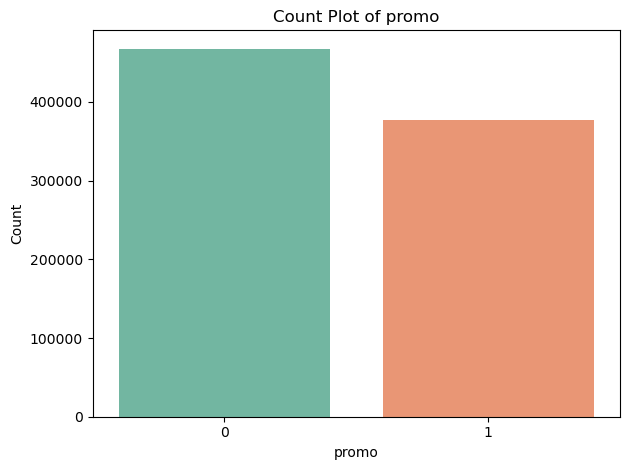

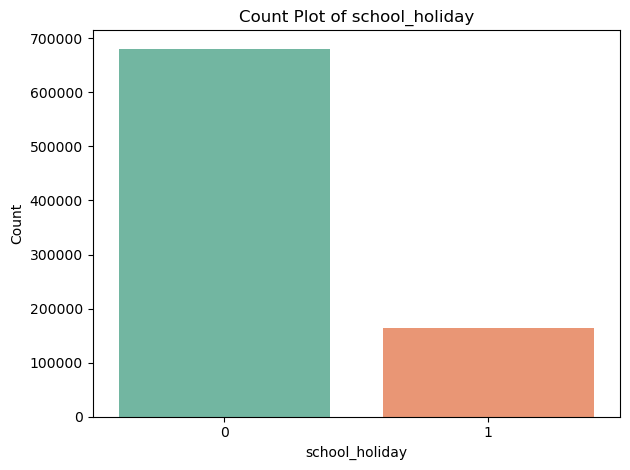

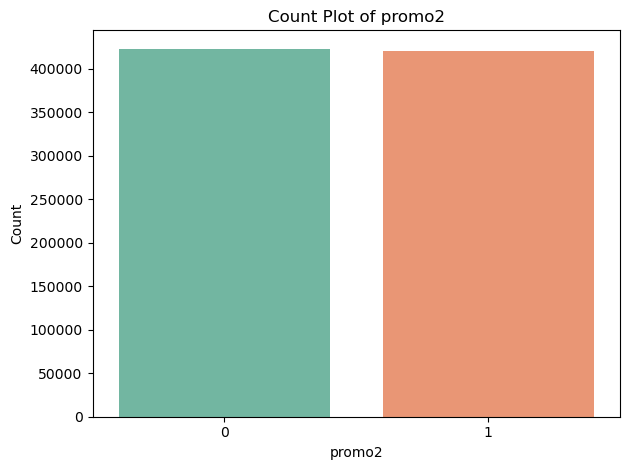

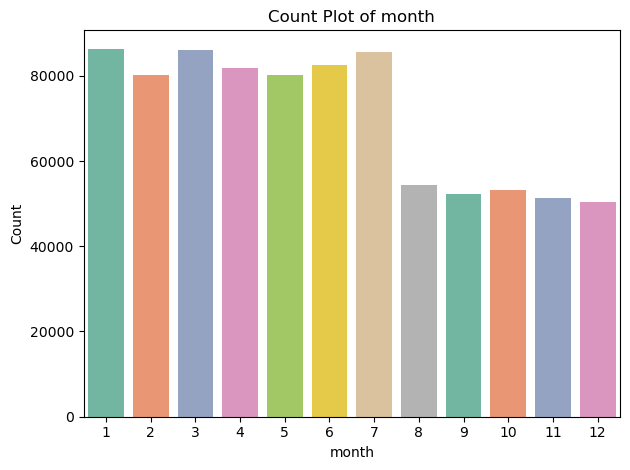

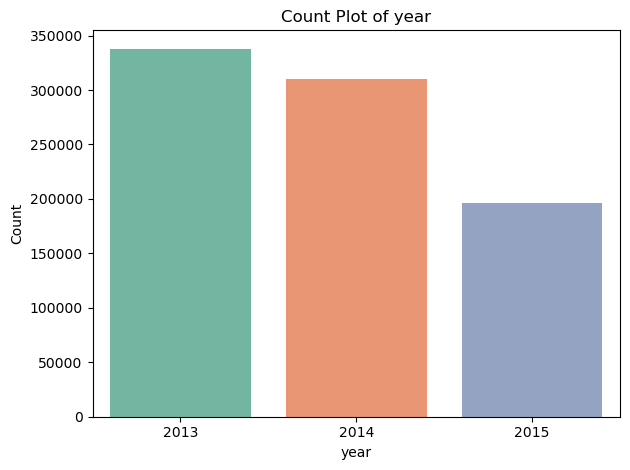

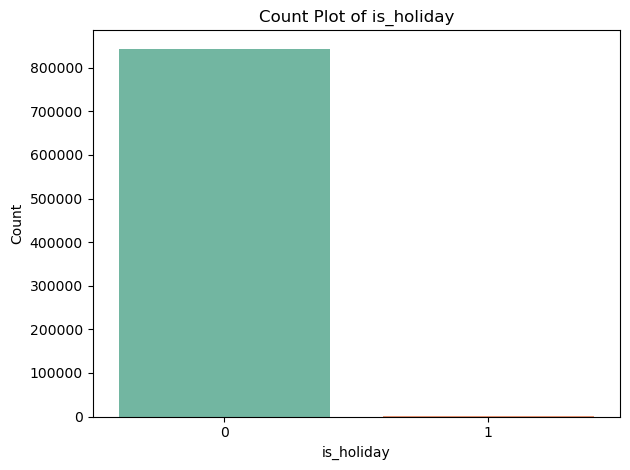

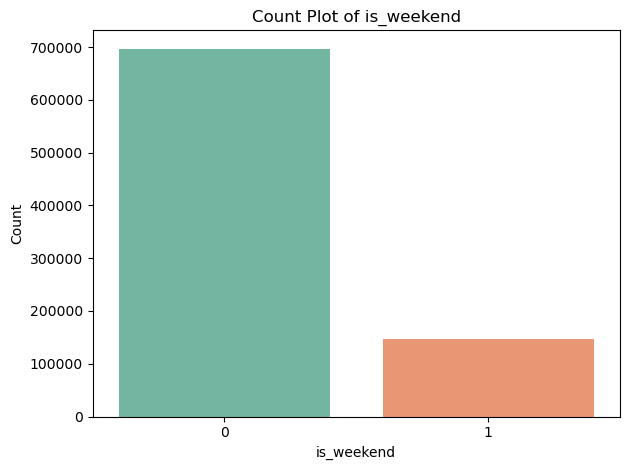

In [109]:
#Lets look at the distribution of all the categorical variables using countplot()

for col in cat_cols:
    sns.countplot(store_df, x = col, palette = "Set2")
    plt.title("Count Plot of " + col)
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

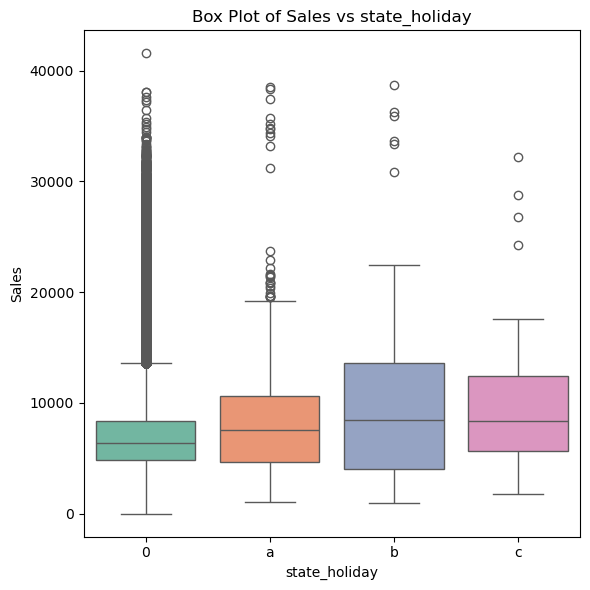

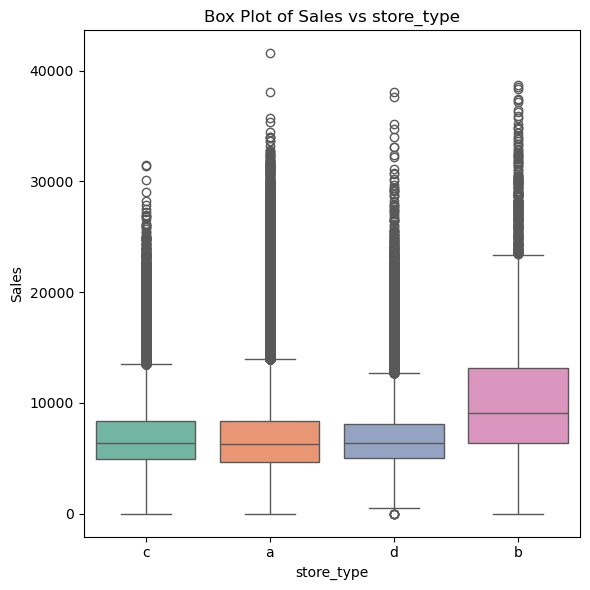

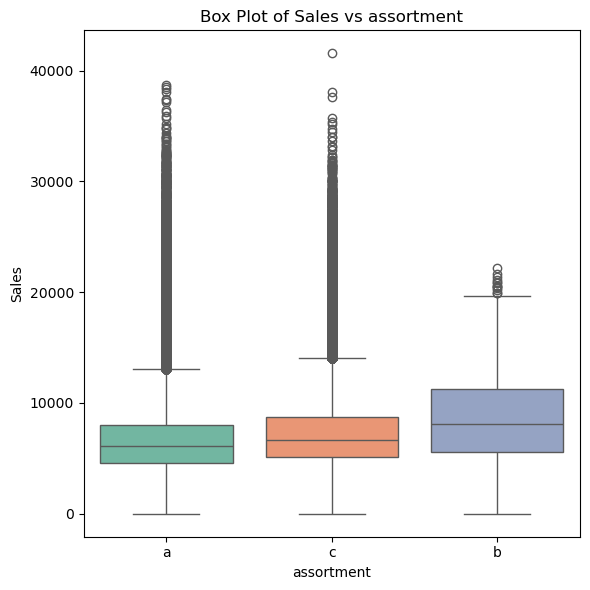

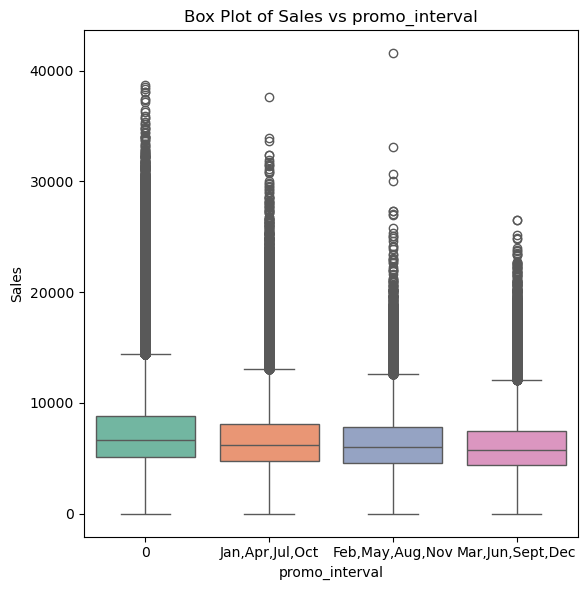

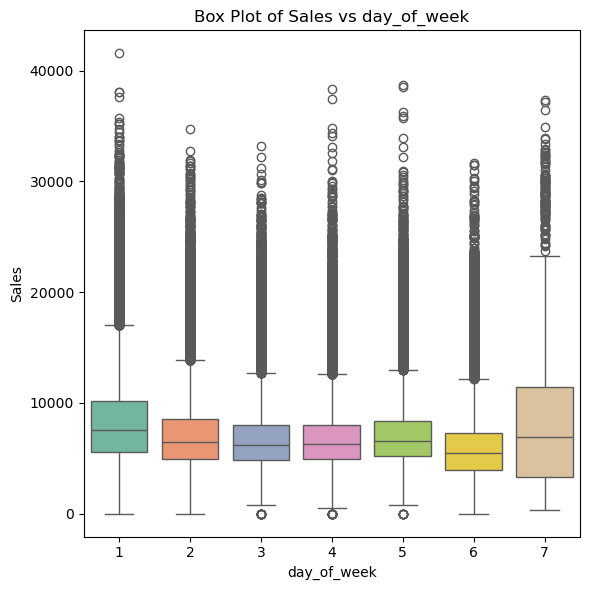

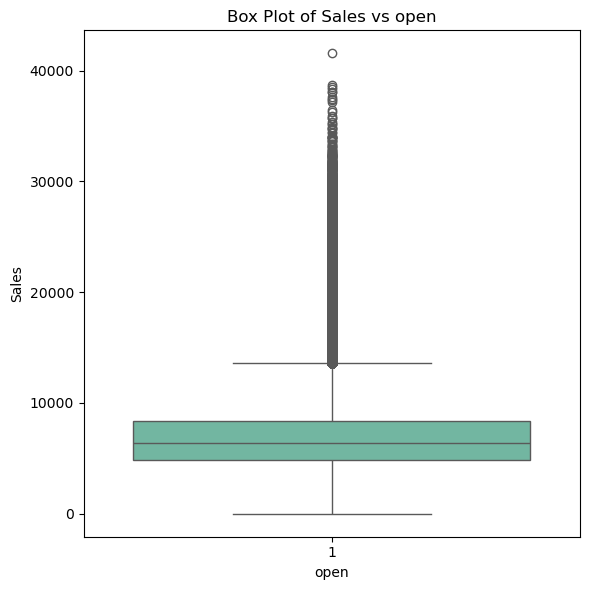

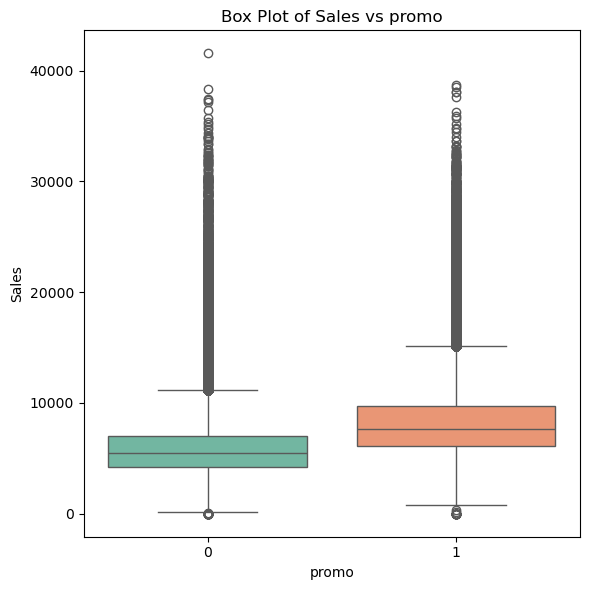

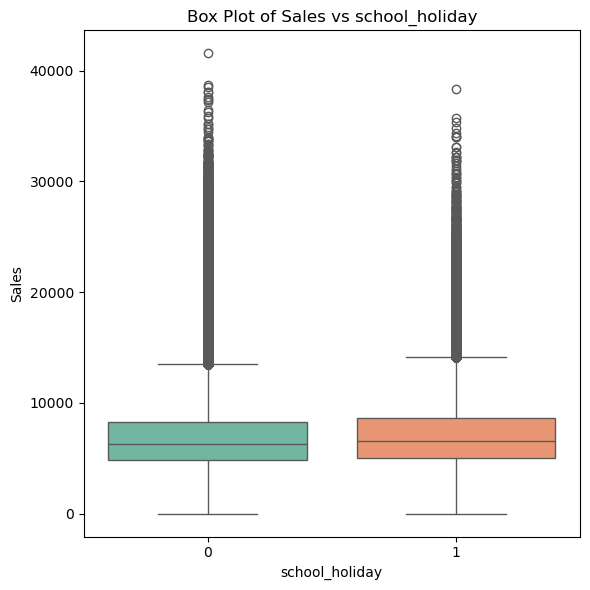

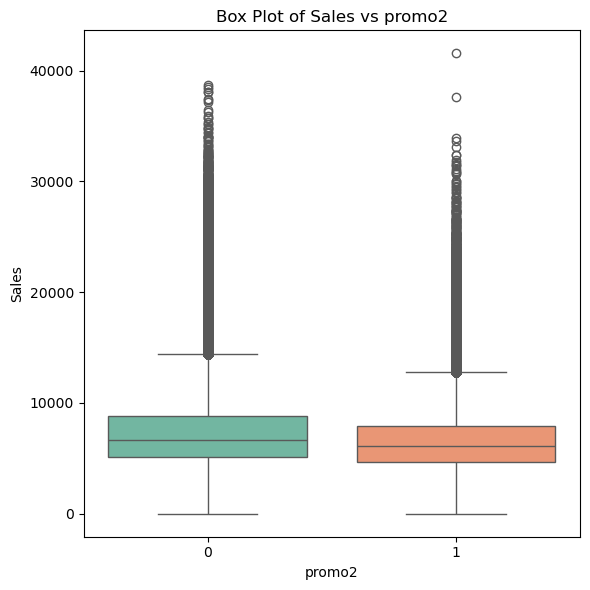

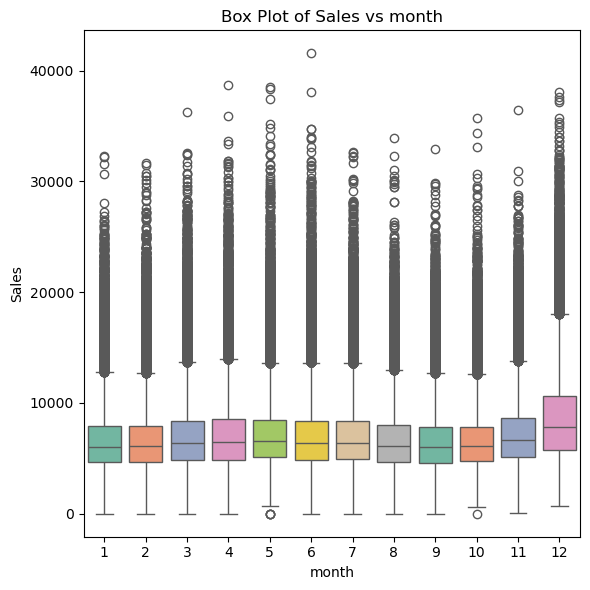

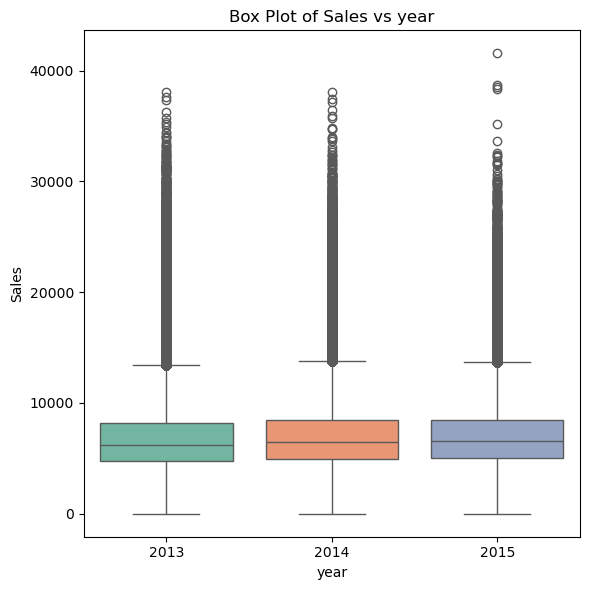

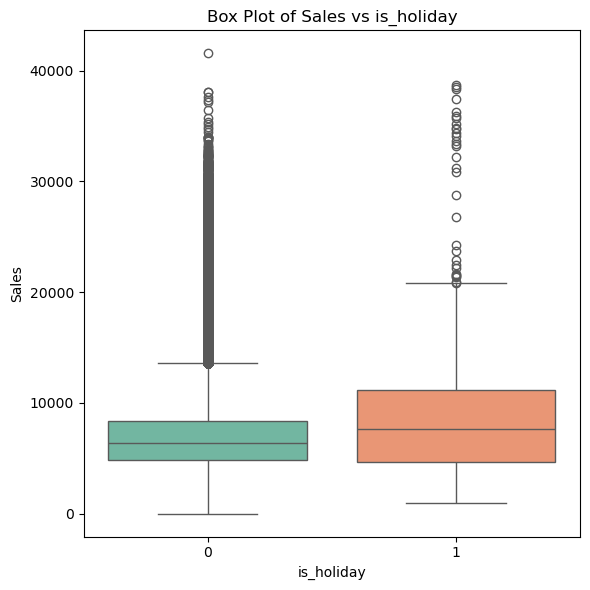

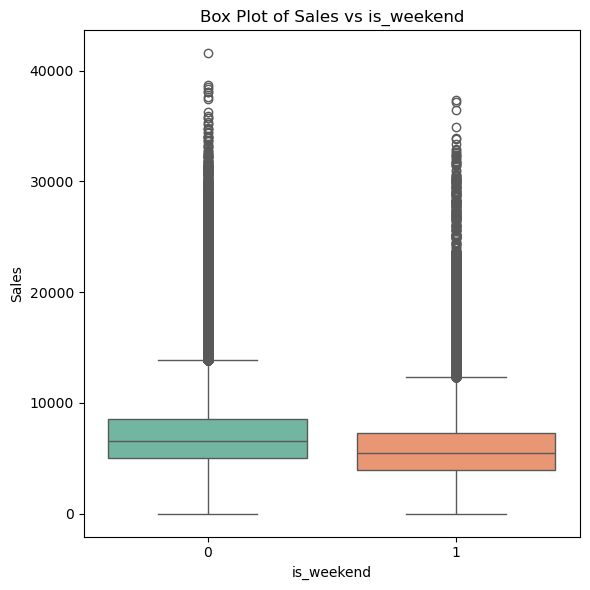

In [111]:
#Box plot of categorical columns vs sales
for col in cat_cols:
    plt.figure(figsize = (6,6))
    sns.boxplot(store_df, y = 'sales', x = col, palette = "Set2")
    plt.title("Box Plot of " + 'Sales' + " vs " + col)
    plt.ylabel("Sales")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#Outliers occuring in every month, whether promo on or no, whether weekend or no, whether holiday or no, 
#so no relation to seasonality or special event like promo or flash sale, so outliers are signal and not noise

#The training dataset contains values of 2.5 years (01-Jan-2013 to 31-Jul-2015) even though 5 months of 2015 are missing the box plots 
# across each month and year are similarly spread. This tells us that sales patterns are remarkably stable across time. 
# In other words, seasonality and central tendencies like median sales were consistent.
# Monthly sales behavior is predictable and not dependent on full-year coverage.
# 2015's partial data (Jan–Jul) still mirrors full years.



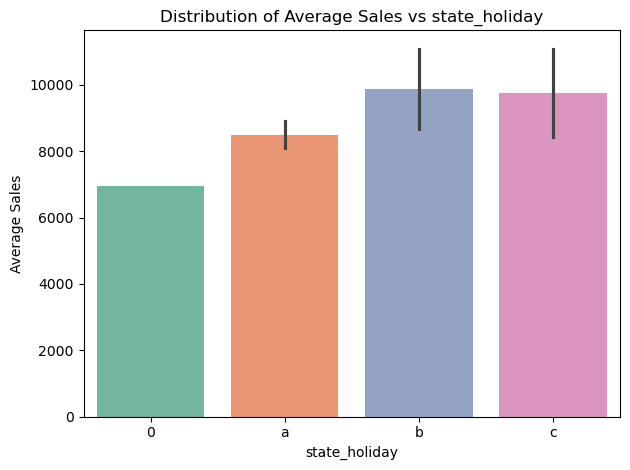

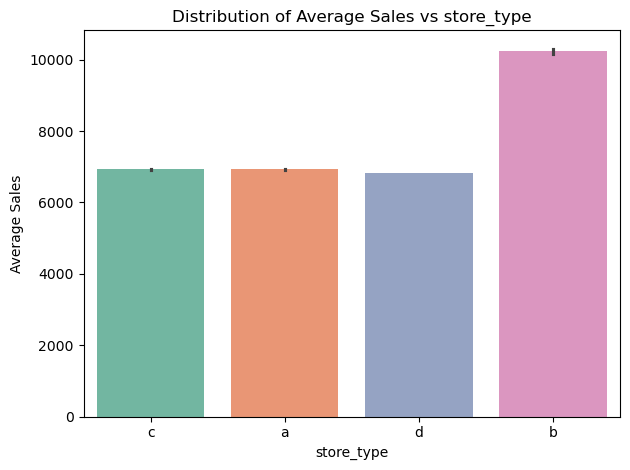

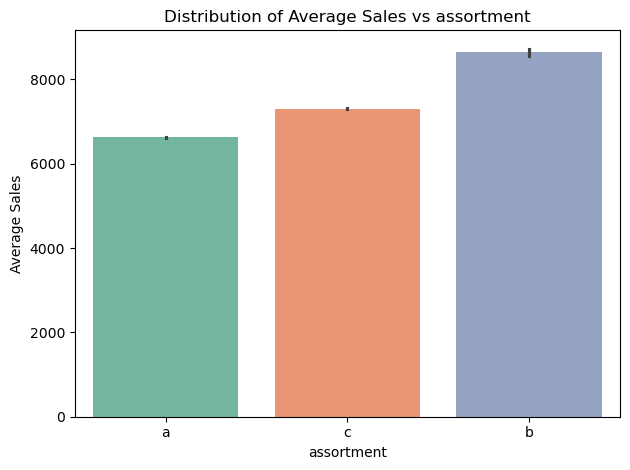

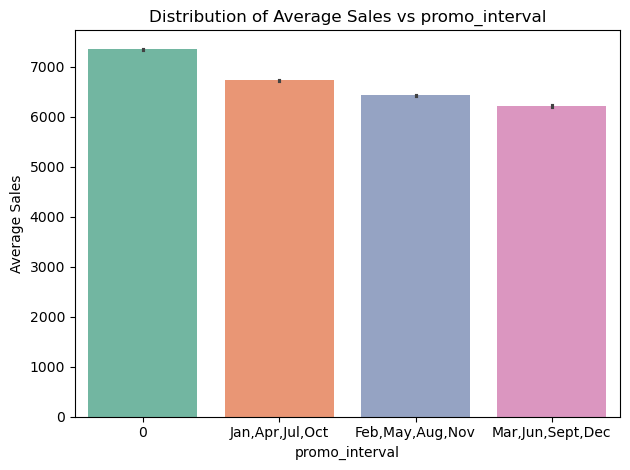

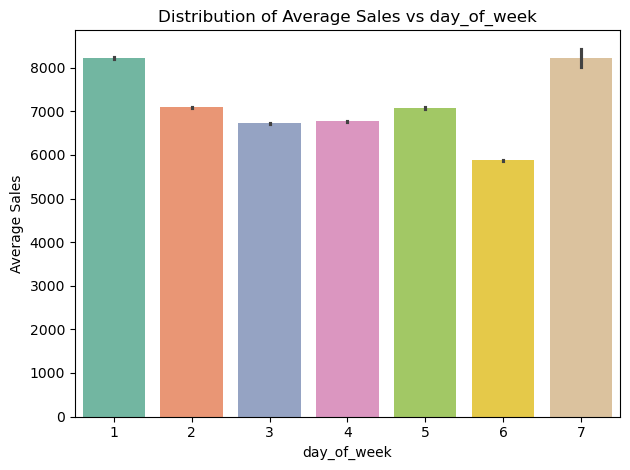

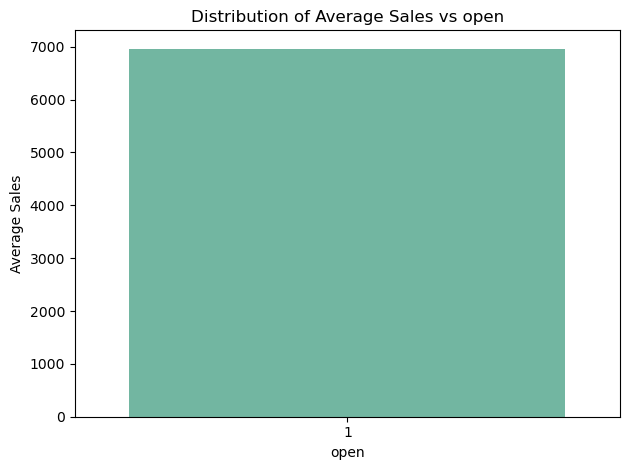

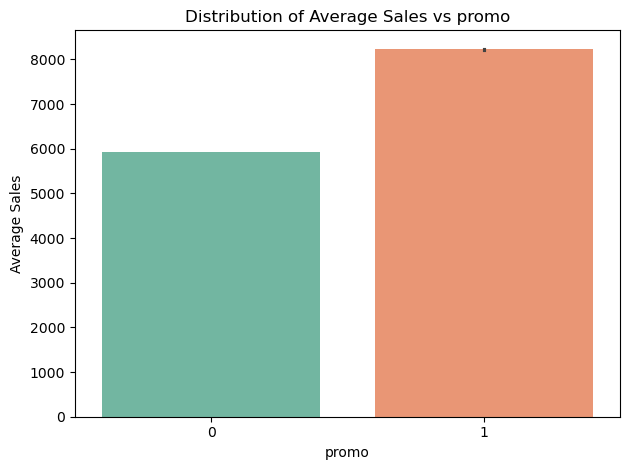

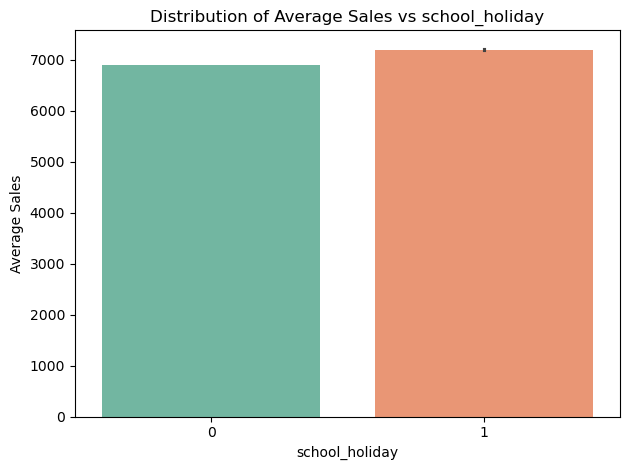

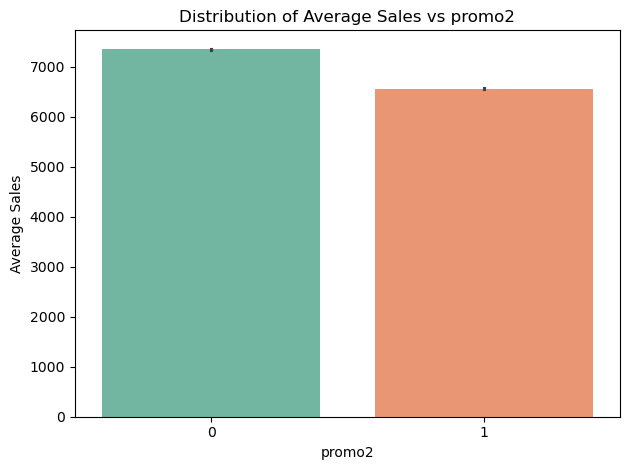

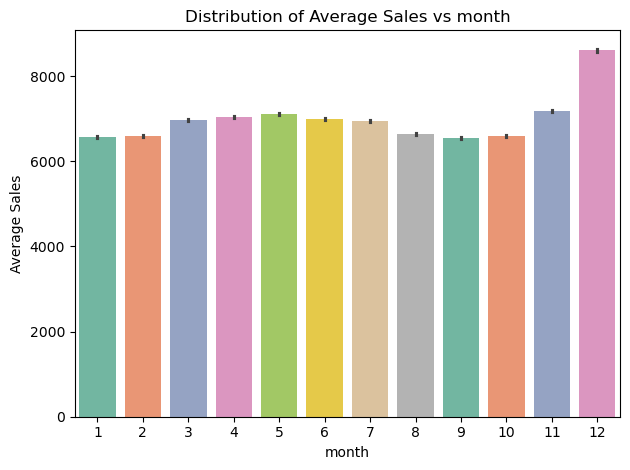

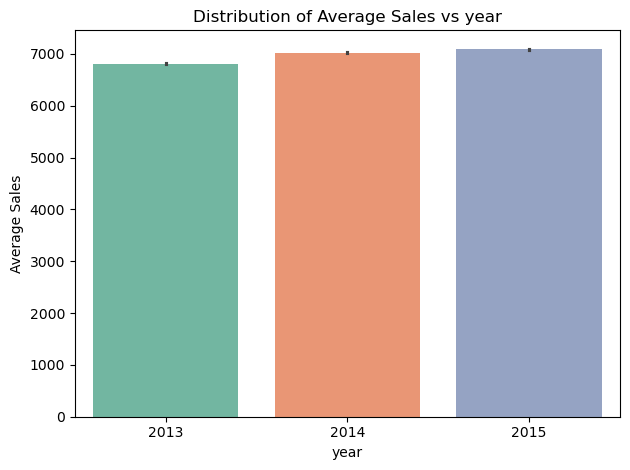

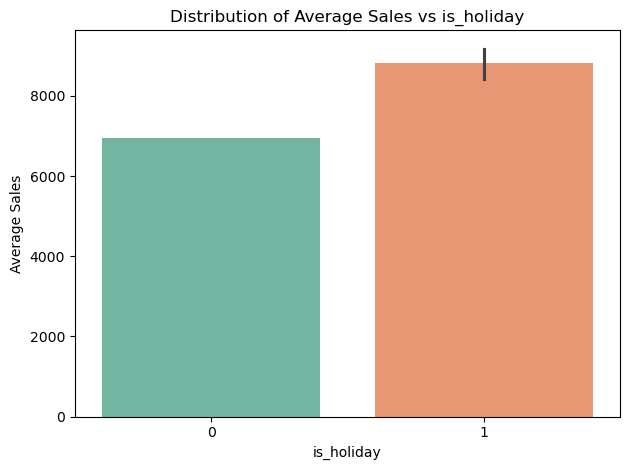

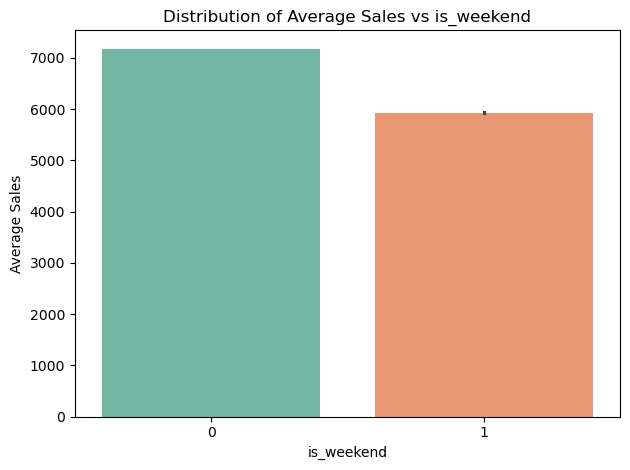

In [113]:
#Lets look at the distribution of Sales (avg) vs all the categorical variables using barplot()

for col in cat_cols:
    sns.barplot(store_df, x = col, y = 'sales', palette = "Set2")
    plt.title("Distribution of Average Sales vs " + col)
    plt.ylabel("Average Sales")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#Average sales for state_holidays is high compared to days without state holiday whereas total sales on state holiday is low
#maybe because number of holidays are less hence the average is higher

#Average sales for b store_type is highest compared to others though its total sales were the lowest
#because the number of b store_type is very low

#Average sales for b assortment is highest compared to others though its total sales were the lowest
#because the number of b assortment stores is very low

#Average sales for day_of_week 7 is highest compared to others though its total sales were the lowest
#As in many cases stores are closed on Sunday (day 7) so the number of day 7 rows were less

#Average sales for month 12 is highest compared to others though its total sales were on the lower end
#because Dec days were less as Dec 2015 data is not provided. 

#Average sales for year 2015 is similar to others though its total sales was low as only half year data is provided.

#Average sales on a holiday is higher than that of no holiday whereas total sales on holiday is low 
#maybe because number of holidays are less hence the average is higher

#Average sales on a weekend is higher than that of no weekend whereas total sales on weekend is low 
#maybe because number of weekends are less hence the average is higher


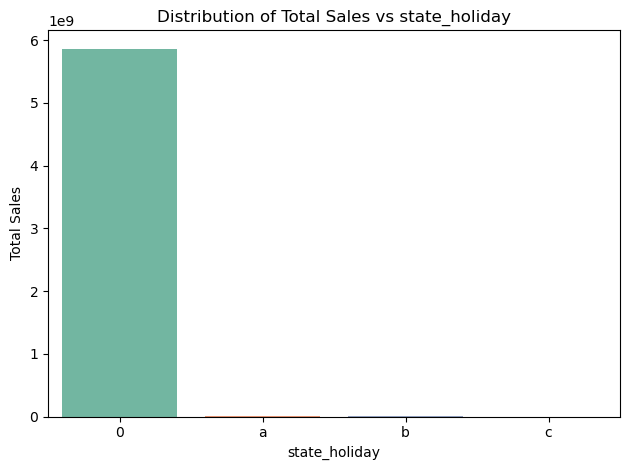

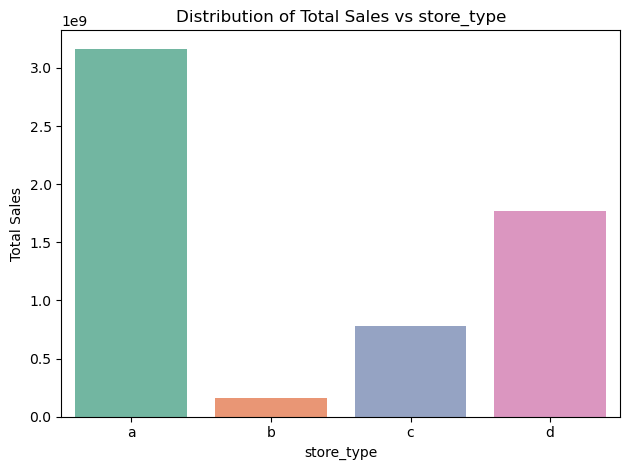

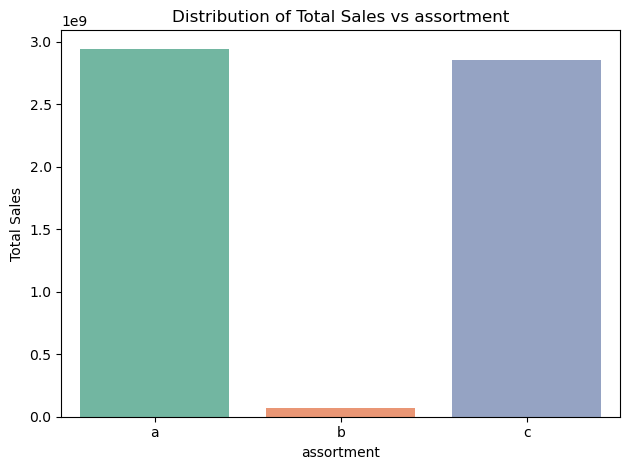

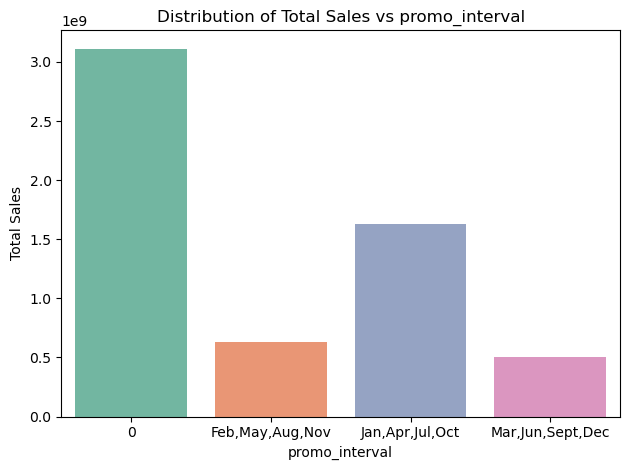

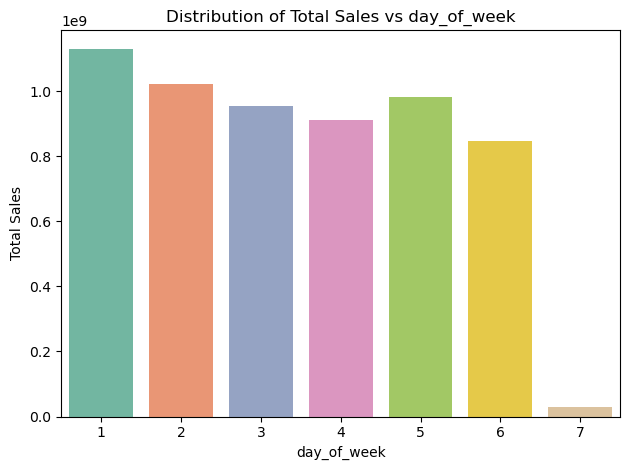

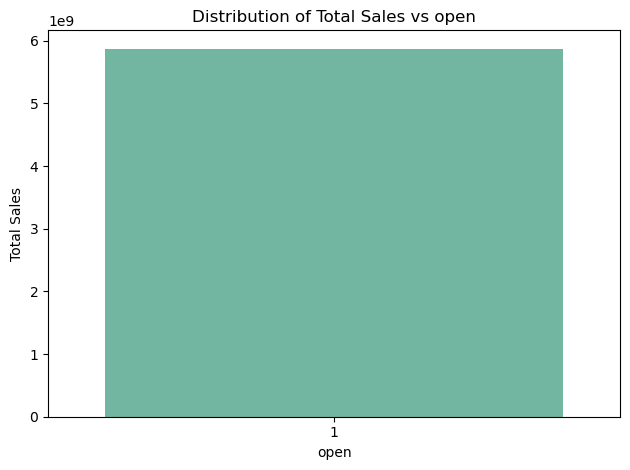

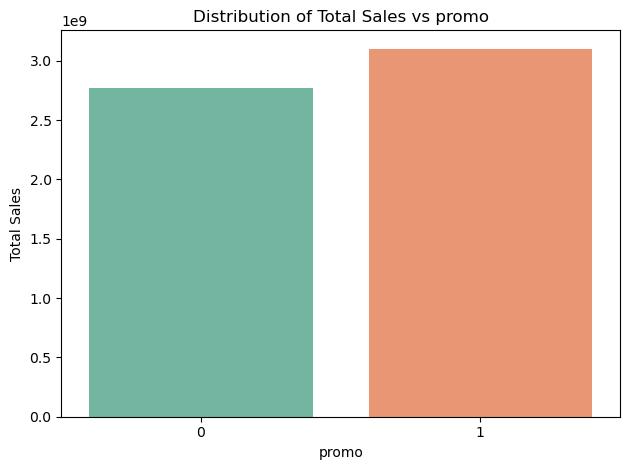

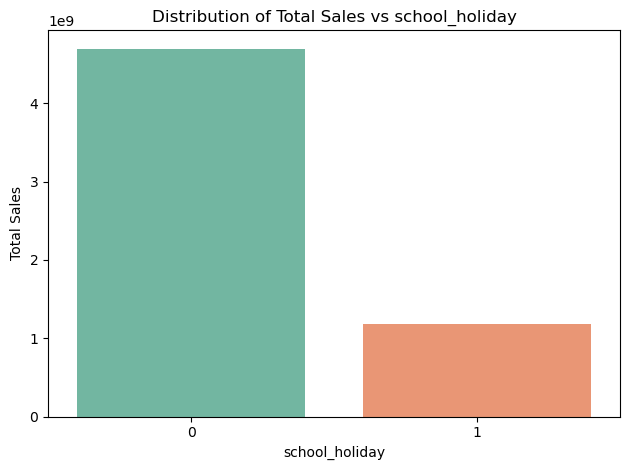

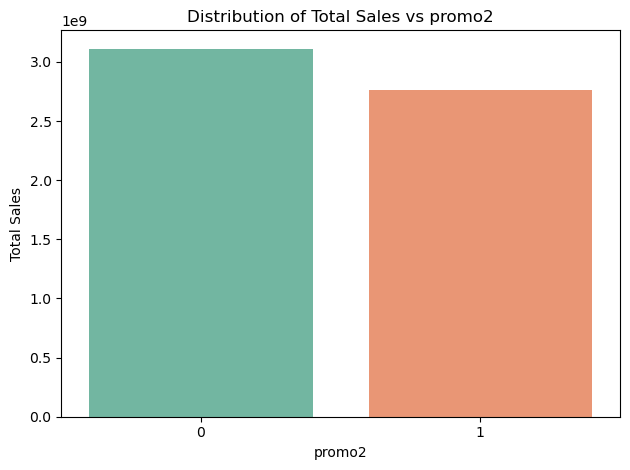

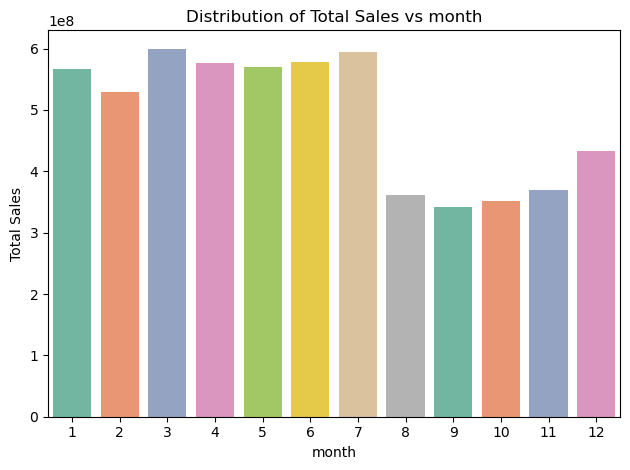

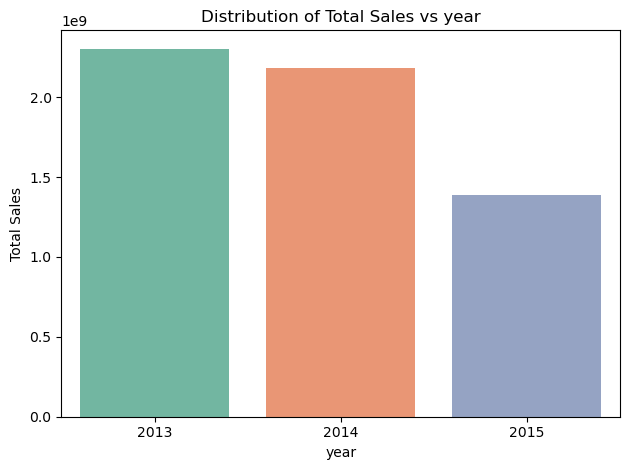

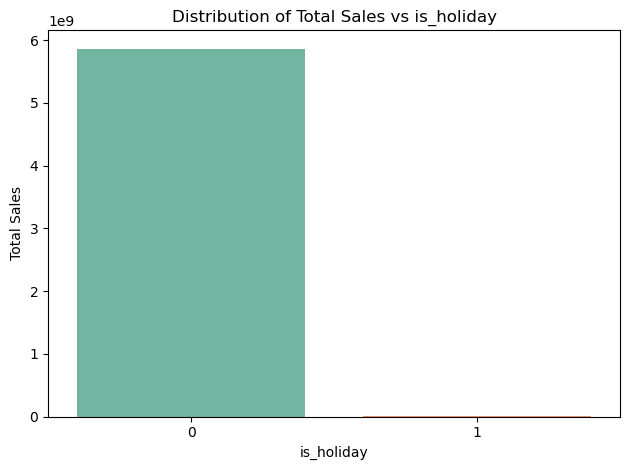

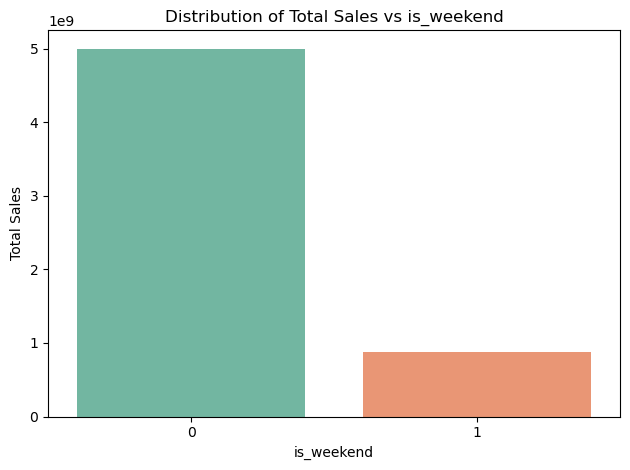

In [114]:
#Bar Plot of total sales vs categorical columns

for col in cat_cols:
    sales_sum = store_df.groupby(col)['sales'].sum().reset_index()
    sns.barplot(sales_sum, y = 'sales', x = col, palette = 'Set2')
    plt.title("Distribution of Total Sales vs " + col)
    plt.ylabel("Total Sales")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# Total sales on Sunday (#7) is the lowest.
# Months 8 to 12 have low total Sales as these months' data is not available for 2015.
# Year 2015 has low total Sales as only 7 months data of that year is available.
# Store type b and assortment b also had lowest total sales.
# Similar trend seen here as that of in count plot, meaning if the number of instances were less then 
#total sales of those instance also was less.

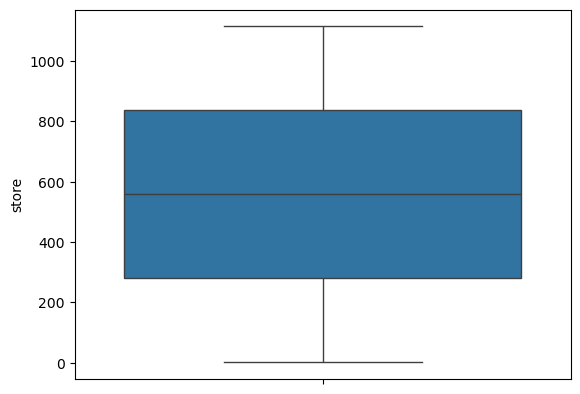

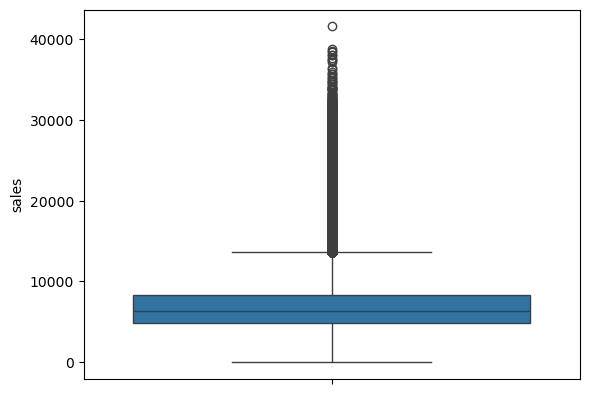

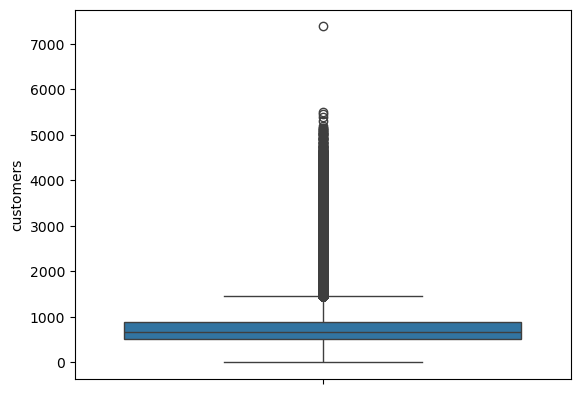

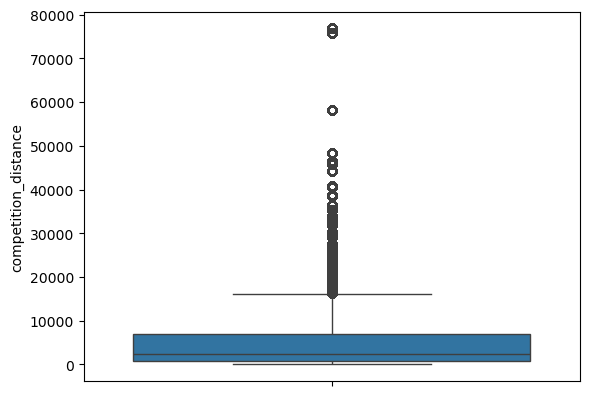

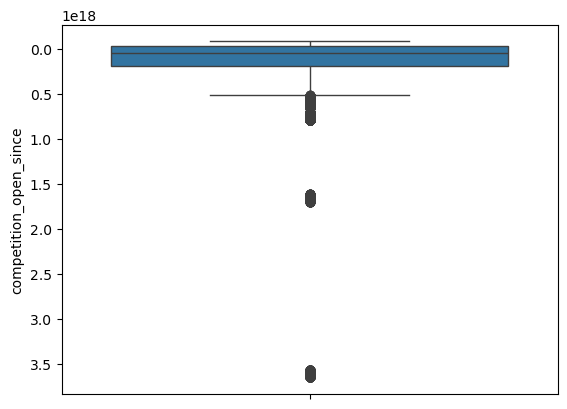

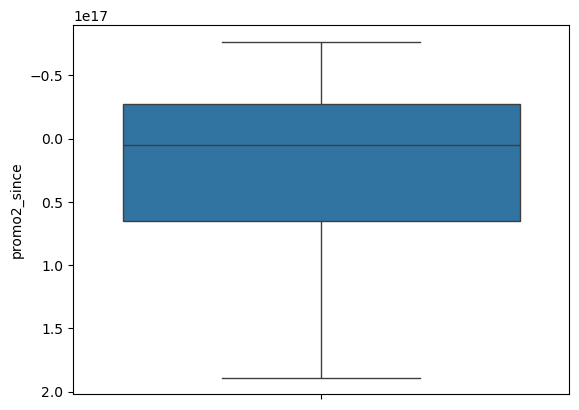

In [117]:
#Let's look at the box plot of numerical columns

for col in num_cols:
    sns.boxplot(store_df, y = col)
    plt.show()

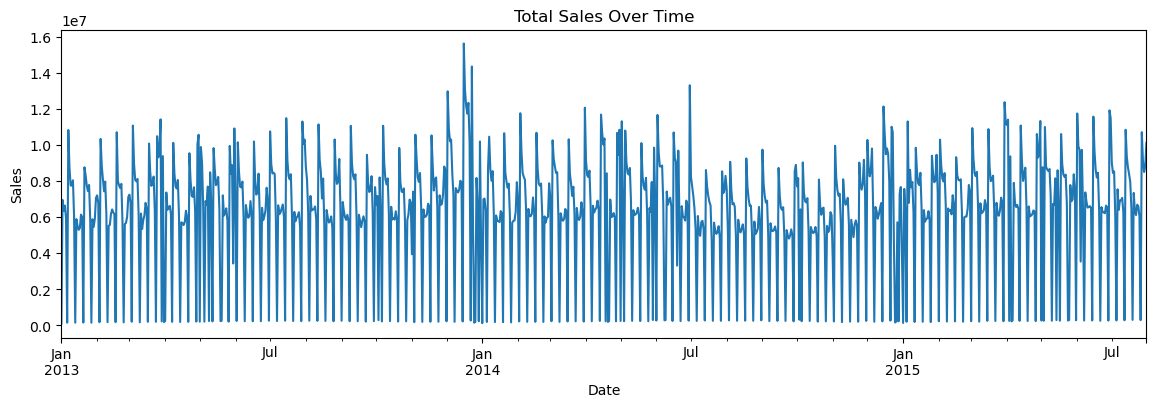

In [119]:
#Overall Sales trend over time: if sales are generally rising, falling, or stable over years.
store_df.groupby('date')['sales'].sum().plot(figsize=(14, 4))
plt.title("Total Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

#This shows there are spikes during year end indicating holiday season and overall a stable trend throughout.

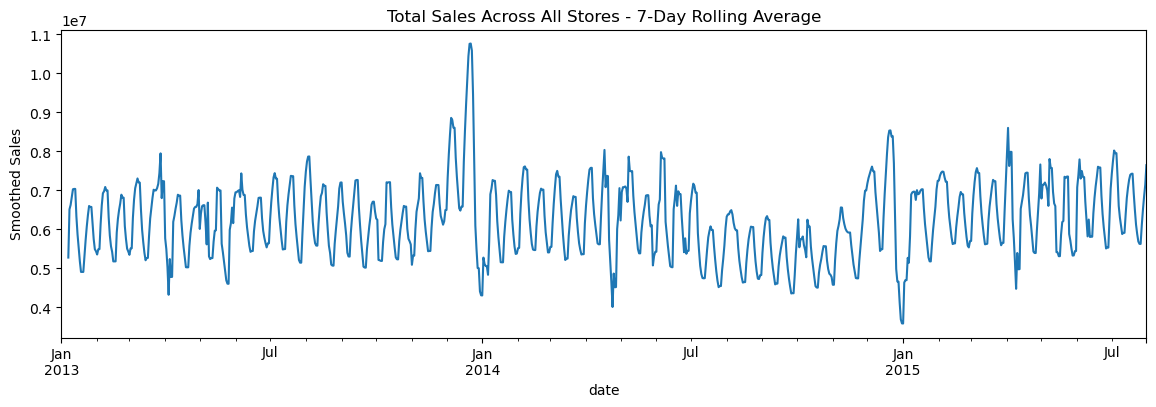

In [121]:
# Sum total sales per calendar date across all stores
daily_sales = store_df.groupby('date')['sales'].sum()

#Apply 7-day rolling average
daily_sales.rolling(window = 7).mean().plot(figsize=(14,4))
plt.title("Total Sales Across All Stores - 7-Day Rolling Average")
plt.ylabel("Smoothed Sales")
plt.show()

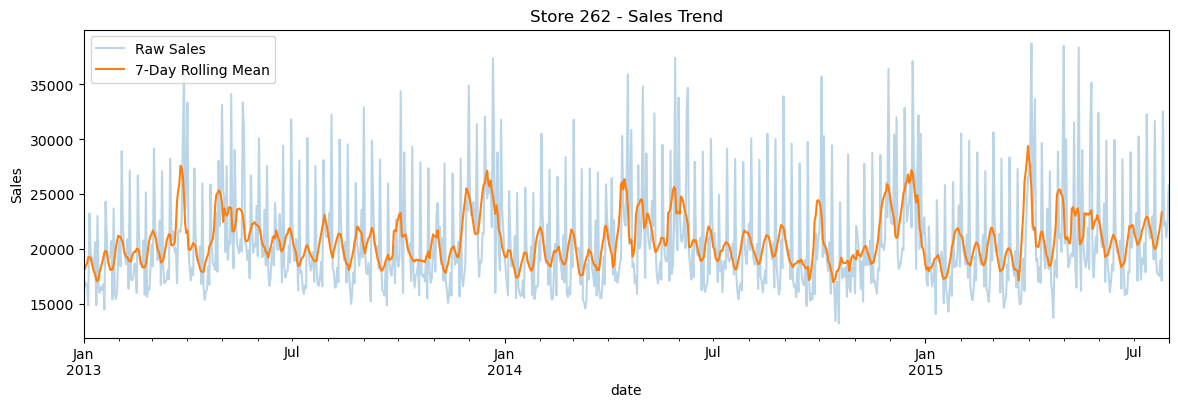

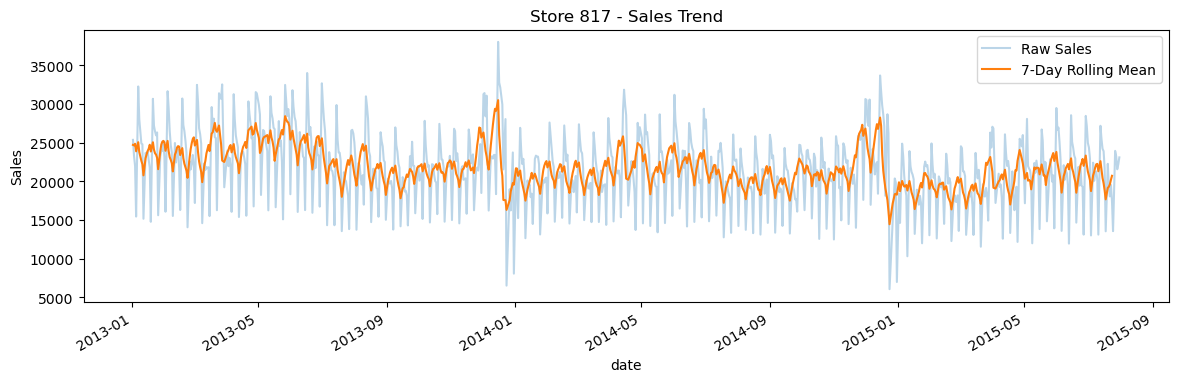

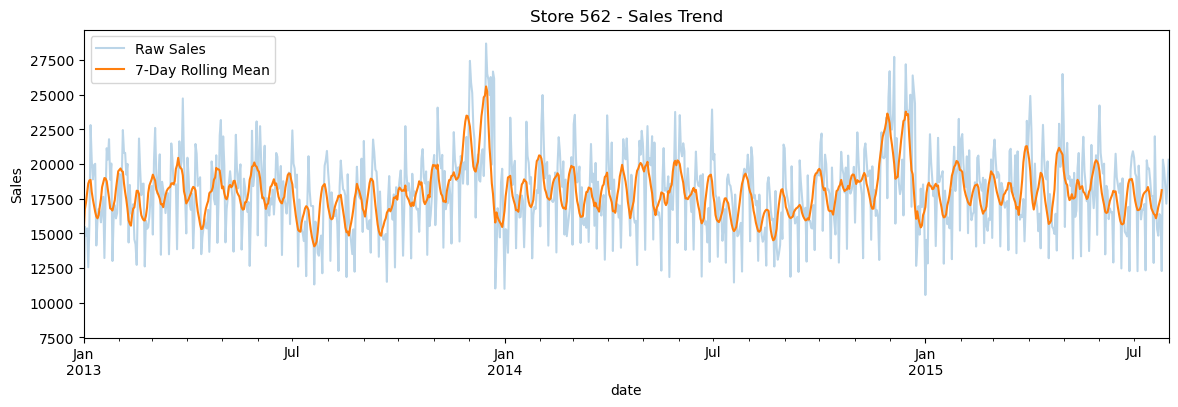

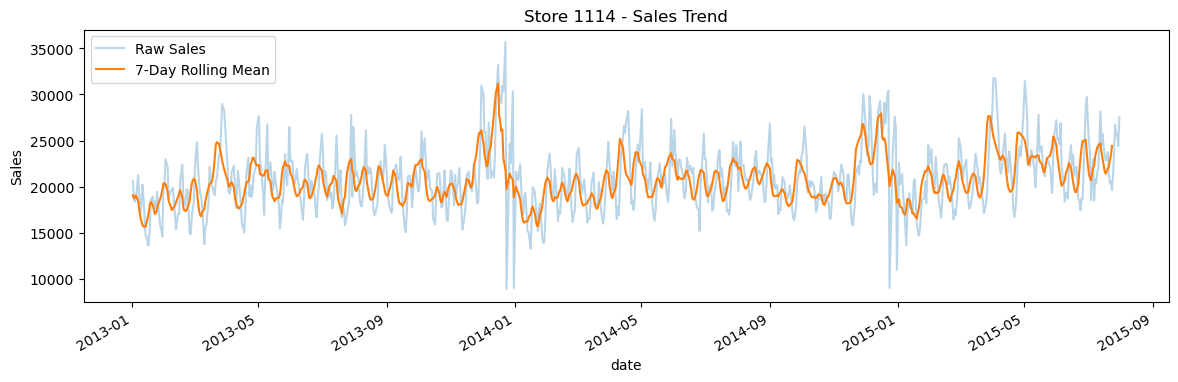

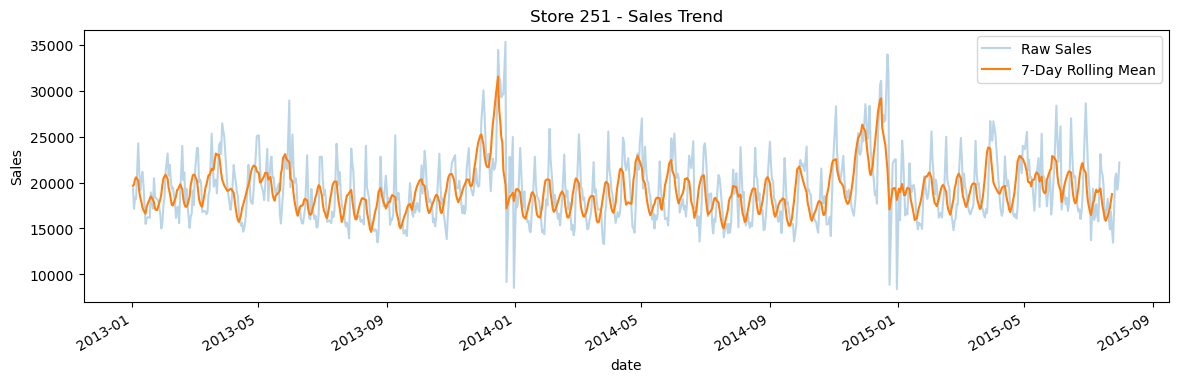

In [123]:
top_stores = store_df.groupby('store')['sales'].sum().sort_values(ascending=False).head(5).index

for store_id in top_stores:
    store_subset = store_df[store_df['store'] == store_id].set_index('date')
    
    plt.figure(figsize=(14, 4))
    store_subset['sales'].plot(alpha=0.3, label='Raw Sales')
    store_subset['sales'].rolling(window=7).mean().plot(label='7-Day Rolling Mean')
    plt.title(f"Store {store_id} - Sales Trend")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

In [125]:
# Analyzing store level trends

store_df['tier'] = pd.qcut(
    store_df.groupby('store')['sales'].transform('sum'),
    q = 4,
    labels = ['low', 'medium-low', 'medium-high', 'high']
)

#Create a list of unique stores with their tier
store_tiers = store_df[['store', 'tier']].drop_duplicates()

#Sample 3 stores per tier
sampled_stores = store_tiers.groupby('tier').sample(n =3, random_state = 5)['store'].tolist()
sampled_stores

[204, 407, 1038, 511, 45, 537, 685, 116, 925, 421, 595, 562]

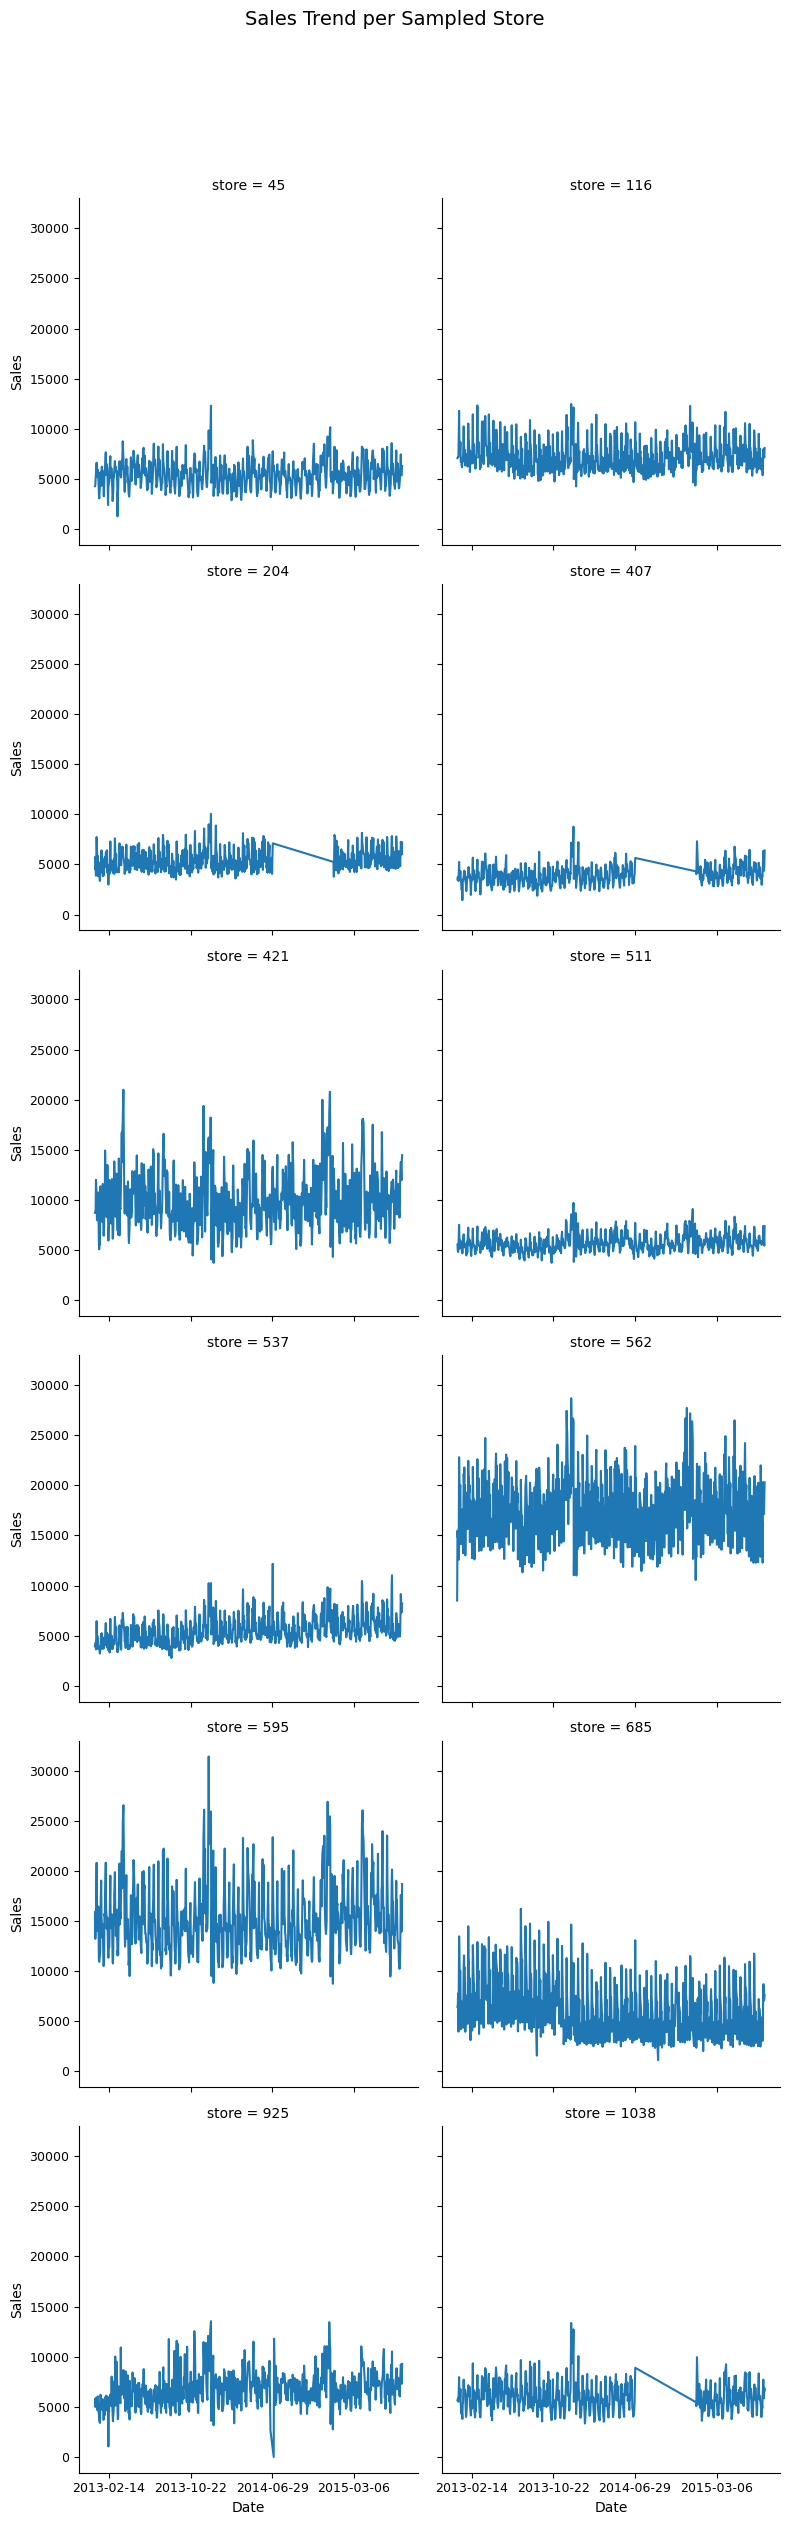

In [127]:
# Now use these sampled stores in the FacetGrid plot to see sales trend of individual stores

g = sns.FacetGrid(store_df[store_df['store'].isin(sampled_stores)], col = 'store', col_wrap = 2, height = 4)
g.map(sns.lineplot, 'date', 'sales')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # ~ spread-out ticks
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=9)
    ax.set_ylabel("Sales", fontsize=10)
    ax.set_xlabel("Date", fontsize=10)
    
g.fig.suptitle("Sales Trend per Sampled Store", y = 1.05, fontsize = 14)
plt.tight_layout()
plt.show()

#Sudden drops from the facet grid indicates that for some stores the sales data is missing for some days,
#It could be those days when stores were closed for refurbishment as mentioned in the problem statement.

### Feature Engineering

In [136]:
# Columns to encode
encoding_cols = ['state_holiday', 'store_type','assortment','promo_interval']

#Copy of the dataframe
df_encoded = store_df.copy()

#Apply Label Encoders
label_encoders = {}

for col in encoding_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le # Save the encoder in case you need to inverse transform or use on test set

#Cyclic features: month, day_of_week
# Encode month (1 to 12)
df_encoded['month_sin'] = np.sin(2 * np.pi * df_encoded['month'] / 12)
df_encoded['month_cos'] = np.cos(2 * np.pi * df_encoded['month'] / 12)

# Encode day_of_week (1 to 7 or 0 to 6 depending on your dataset)
df_encoded['dow_sin'] = np.sin(2 * np.pi * df_encoded['day_of_week'] / 7)
df_encoded['dow_cos'] = np.cos(2 * np.pi * df_encoded['day_of_week'] / 7)

df_encoded.drop(['tier'], axis = 1, inplace = True)

In [138]:
check_set = df_encoded.copy()
check_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype          
---  ------                       --------------   -----          
 0   store                        844392 non-null  int64          
 1   day_of_week                  844392 non-null  int64          
 2   date                         844392 non-null  datetime64[ns] 
 3   sales                        844392 non-null  int64          
 4   customers                    844392 non-null  int64          
 5   open                         844392 non-null  int64          
 6   promo                        844392 non-null  int64          
 7   state_holiday                844392 non-null  int64          
 8   school_holiday               844392 non-null  int64          
 9   store_type                   844392 non-null  int64          
 10  assortment                   844392 non-null  int64          
 11  competition_d

In [140]:
#Converting timedelta cols to numeric
timedelta_cols = check_set.select_dtypes(include = 'timedelta').columns

for col in timedelta_cols:
    check_set[col] = check_set[col].dt.days
    

In [142]:
#Has unnecessary features
check_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   store                        844392 non-null  int64         
 1   day_of_week                  844392 non-null  int64         
 2   date                         844392 non-null  datetime64[ns]
 3   sales                        844392 non-null  int64         
 4   customers                    844392 non-null  int64         
 5   open                         844392 non-null  int64         
 6   promo                        844392 non-null  int64         
 7   state_holiday                844392 non-null  int64         
 8   school_holiday               844392 non-null  int64         
 9   store_type                   844392 non-null  int64         
 10  assortment                   844392 non-null  int64         
 11  competition_distance      

In [144]:
remove_cols = ['customers', 'open', 'month', 'competition_open_since_date', 'promo2_since_date', 'day_of_week']
check_set_df = check_set.drop(columns = remove_cols)
check_set_df.info()

#Check_set_df contains timedelta64 cols converted to int and it doesn't have any unnecessary columns that we cannot create or have in 
#test set or not needed in test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   store                   844392 non-null  int64         
 1   date                    844392 non-null  datetime64[ns]
 2   sales                   844392 non-null  int64         
 3   promo                   844392 non-null  int64         
 4   state_holiday           844392 non-null  int64         
 5   school_holiday          844392 non-null  int64         
 6   store_type              844392 non-null  int64         
 7   assortment              844392 non-null  int64         
 8   competition_distance    844392 non-null  float64       
 9   promo2                  844392 non-null  int64         
 10  promo_interval          844392 non-null  int64         
 11  year                    844392 non-null  int32         
 12  competition_open_since  844392

<Axes: >

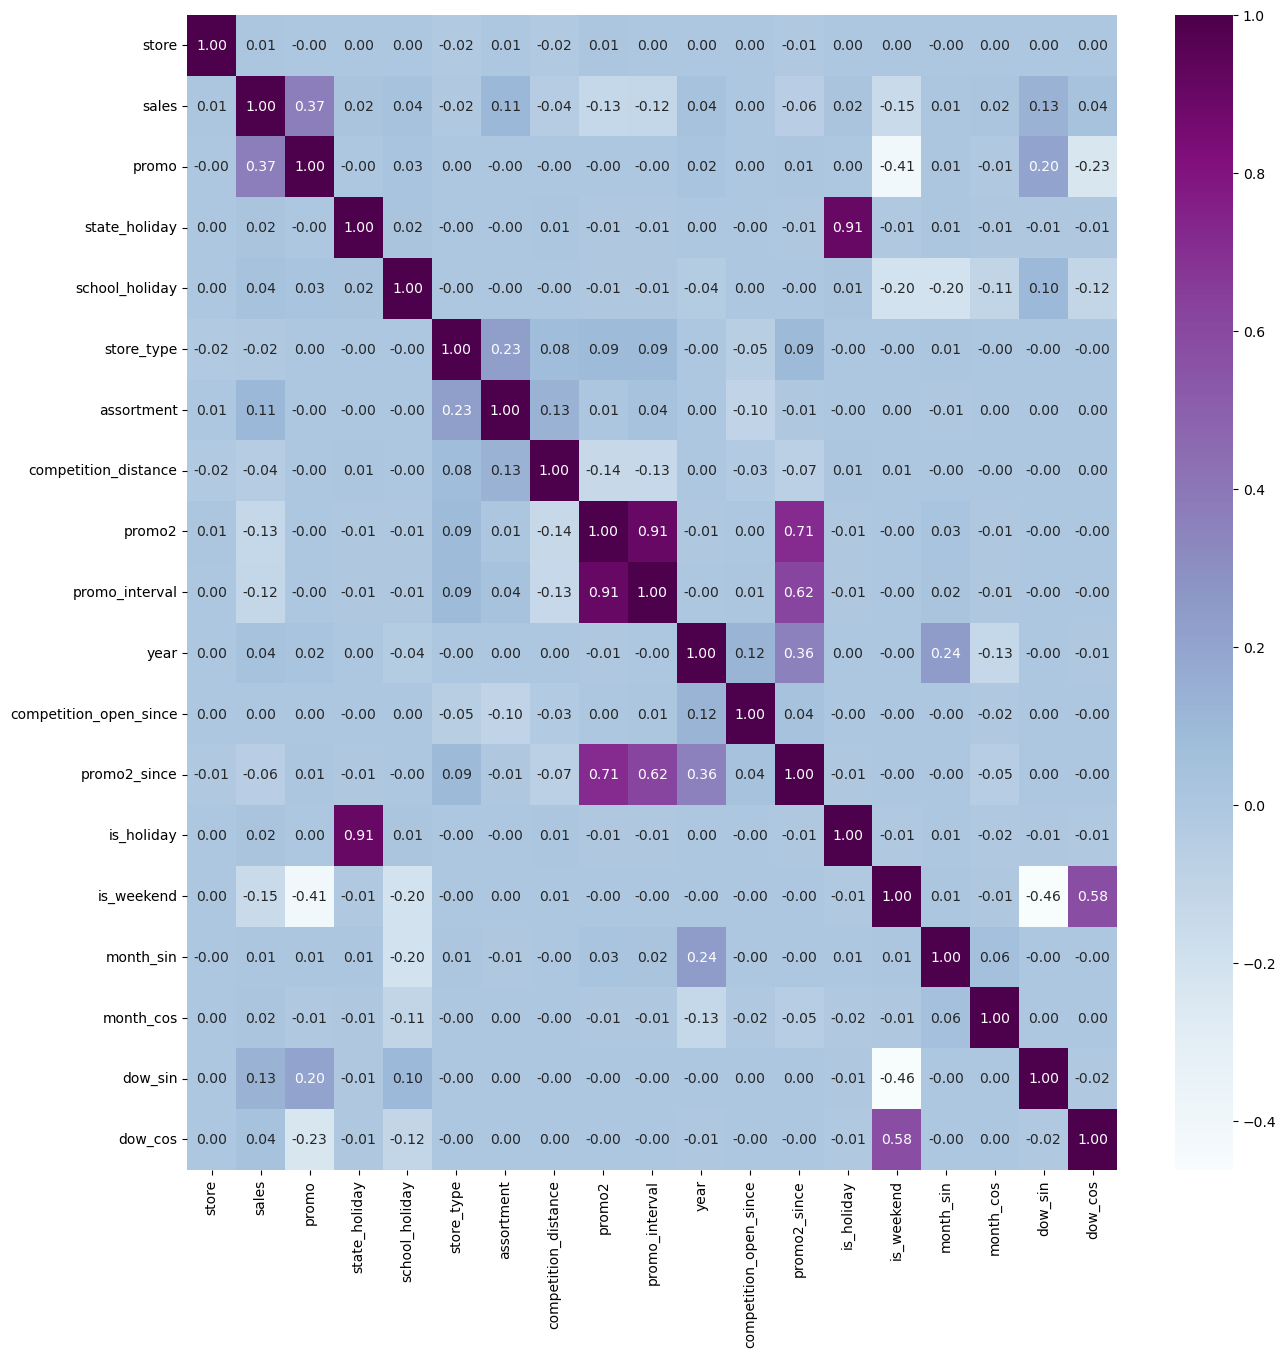

In [146]:
#Heatmap to see correlation of all variables 
#Correlation coefficient of 2 variables is independent of the presence of other variables but depends on the size of the dataset.

plt.figure(figsize = (15,15))
sns.heatmap(check_set_df.select_dtypes(include = 'number').corr(), annot = True, fmt = ".2f", cmap = "BuPu")

### Train & Validation Set

In [149]:
check_train_val_full = check_set_df[check_set_df['date'] < '2015-08-01'].sort_values('date')

check_train_val_len = len(check_train_val_full)
check_train_size = int(check_train_val_len * 0.8)

check_train_set = check_train_val_full.iloc[:check_train_size]
check_val_set = check_train_val_full.iloc[check_train_size:]

In [151]:
check_X_train = check_train_set.drop(columns=['date', 'sales'])
check_y_train = check_train_set['sales']

check_X_val = check_val_set.drop(columns=['date', 'sales'])
check_y_val = check_val_set['sales']

### Developing the test set

In [156]:
#Make all column headers to lower case and making all names to snake case from camel case- test dataset
import re
test.columns = [re.sub(r'(?<!^)(?=[A-Z])','_', col).lower() for col in test.columns]

print(test.columns)

Index(['id', 'store', 'day_of_week', 'date', 'open', 'promo', 'state_holiday',
       'school_holiday'],
      dtype='object')


In [158]:
#Make all column headers to lower case and making all names to snake case from camel case- store dataset
import re
store.columns = [re.sub(r'(?<!^)(?=[A-Z])','_', col).lower() for col in store.columns]

print(store.columns)

Index(['store', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval'],
      dtype='object')


In [160]:
test_store_df = pd.merge(test, store, how = 'left', on = 'store')
test_store_df.head()

,id,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [162]:
#Convert date column to datetype
test_store_df['date'] = pd.to_datetime(test_store_df['date'])

#Columns to add: month, year, is_weekend
test_store_df['month'] = pd.to_datetime(test_store_df['date']).dt.month
test_store_df['year'] = pd.to_datetime(test_store_df['date']).dt.month
test_store_df['is_weekend'] = test_store_df['day_of_week'].apply(lambda x: 1 if x in [6,7] else 0)
test_store_df['is_holiday'] = test_store_df ['state_holiday'].astype(str).apply(lambda x:0 if x == '0' else 1)

test_store_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            41088 non-null  int64         
 1   store                         41088 non-null  int64         
 2   day_of_week                   41088 non-null  int64         
 3   date                          41088 non-null  datetime64[ns]
 4   open                          41077 non-null  float64       
 5   promo                         41088 non-null  int64         
 6   state_holiday                 41088 non-null  object        
 7   school_holiday                41088 non-null  int64         
 8   store_type                    41088 non-null  object        
 9   assortment                    41088 non-null  object        
 10  competition_distance          40992 non-null  float64       
 11  competition_open_since_month

In [164]:
#Define a large value to indicate 'no nearby competition'
long_distance = test_store_df['competition_distance'].max() + 1000

#Apply conditional update only to rows with missing competition_distance
test_store_df.loc[test_store_df['competition_distance'].isna(), 'competition_distance'] = long_distance

In [166]:

#Finding the max date in the test_store_df dataframe
current_date = pd.to_datetime(test_store_df['date'].max())

print("current date:", current_date)

current date: 2015-09-17 00:00:00


In [168]:
#Fill na competition_open_since_month and competition_open_since_year
test_store_df['competition_open_since_month'].fillna(current_date.month, inplace = True)
test_store_df['competition_open_since_year'].fillna(current_date.year, inplace = True)

In [170]:
test_store_df['competition_open_since_year'] = test_store_df['competition_open_since_year'].astype(int)
test_store_df['competition_open_since_month'] = test_store_df['competition_open_since_month'].astype(int)

In [172]:
test_store_df['competition_open_since_date'] = pd.to_datetime(test_store_df['competition_open_since_year'].astype(str) + '-' +
                                                         test_store_df['competition_open_since_month'].astype(str) + '-01')

In [174]:
test_store_df['competition_open_since'] = test_store_df['date'] - test_store_df['competition_open_since_date']

In [176]:
#Fill na promo2_since_week and promo2_since_year

test_store_df['promo2_since_week'].fillna(1, inplace = True)
test_store_df['promo2_since_year'].fillna(current_date.year, inplace = True)
test_store_df['promo_interval'].fillna(0, inplace = True)

In [178]:
test_store_df['promo2_since_week'] = test_store_df['promo2_since_week'].astype(int)
test_store_df['promo2_since_year'] = test_store_df['promo2_since_year'].astype(int)

In [180]:
test_store_df['promo2_since_date'] = pd.to_datetime(test_store_df['promo2_since_year'].astype(str) + '-' +
                                                    test_store_df['promo2_since_week'].astype(str) + '-1',
                                                    format = '%Y-%W-%w')

In [182]:
test_store_df['promo2_since'] = test_store_df['date'] - test_store_df['promo2_since_date']

In [184]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   id                            41088 non-null  int64          
 1   store                         41088 non-null  int64          
 2   day_of_week                   41088 non-null  int64          
 3   date                          41088 non-null  datetime64[ns] 
 4   open                          41077 non-null  float64        
 5   promo                         41088 non-null  int64          
 6   state_holiday                 41088 non-null  object         
 7   school_holiday                41088 non-null  int64          
 8   store_type                    41088 non-null  object         
 9   assortment                    41088 non-null  object         
 10  competition_distance          41088 non-null  float64        
 11  competition_ope

In [190]:
test_store_df.drop(['competition_open_since_date', 'promo2_since_date', 'competition_open_since_month', 'competition_open_since_year',
                    'promo2_since_week', 'promo2_since_year', 'open'], axis = 1, inplace = True)

In [186]:
#Converting timedelta cols to numeric
timedelta_cols = test_store_df.select_dtypes(include = 'timedelta').columns

for col in timedelta_cols:
    test_store_df[col] = test_store_df[col].dt.days

In [192]:
#Encoding categorical features and adding modifiying 'month' and 'dow' columns

# Columns to encode
test_encoding_cols = ['state_holiday','store_type','assortment','promo_interval']

#Copy of the dataframe
test_store_df_encoded = test_store_df.copy()

#Apply Label Encoders
label_encoders = {}

for col in test_encoding_cols:
    le = LabelEncoder()
    test_store_df_encoded[col] = le.fit_transform(test_store_df_encoded[col].astype(str))
    label_encoders[col] = le # Save the encoder in case you need to inverse transform or use on test set

#Cyclic features: month, day_of_week
# Encode month (1 to 12)
test_store_df_encoded['month_sin'] = np.sin(2 * np.pi * test_store_df_encoded['month'] / 12)
test_store_df_encoded['month_cos'] = np.cos(2 * np.pi * test_store_df_encoded['month'] / 12)

# Encode day_of_week (1 to 7 or 0 to 6 depending on your dataset)
test_store_df_encoded['dow_sin'] = np.sin(2 * np.pi * test_store_df_encoded['day_of_week'] / 7)
test_store_df_encoded['dow_cos'] = np.cos(2 * np.pi * test_store_df_encoded['day_of_week'] / 7)


In [194]:
test_store_df_encoded.drop(['day_of_week', 'month'], axis = 1, inplace = True)

In [198]:
start_date = pd.to_datetime('2015-08-01')
end_date = pd.to_datetime('2015-09-17')

test_set = test_store_df_encoded[
    (test_store_df_encoded['date'] >= start_date) & 
    (test_store_df_encoded['date'] <= end_date)
].sort_values('date')

# Step 4: Confirm date boundaries
print("Min date:", test_set['date'].min())
print("Max date:", test_set['date'].max())


<class 'pandas.core.frame.DataFrame'>
Index: 41088 entries, 41087 to 0
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      41088 non-null  int64         
 1   store                   41088 non-null  int64         
 2   date                    41088 non-null  datetime64[ns]
 3   promo                   41088 non-null  int64         
 4   state_holiday           41088 non-null  int64         
 5   school_holiday          41088 non-null  int64         
 6   store_type              41088 non-null  int64         
 7   assortment              41088 non-null  int64         
 8   competition_distance    41088 non-null  float64       
 9   promo2                  41088 non-null  int64         
 10  promo_interval          41088 non-null  int64         
 11  year                    41088 non-null  int32         
 12  is_weekend              41088 non-null  int64      

In [200]:
test_set.drop(columns= ['id', 'date'], axis = 1, inplace = True )

In [202]:
train_columns = check_X_train.columns.tolist()

# Step 2: Reorder test set columns to match
test_set = test_set[train_columns]
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41088 entries, 41087 to 0
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store                   41088 non-null  int64  
 1   promo                   41088 non-null  int64  
 2   state_holiday           41088 non-null  int64  
 3   school_holiday          41088 non-null  int64  
 4   store_type              41088 non-null  int64  
 5   assortment              41088 non-null  int64  
 6   competition_distance    41088 non-null  float64
 7   promo2                  41088 non-null  int64  
 8   promo_interval          41088 non-null  int64  
 9   year                    41088 non-null  int32  
 10  competition_open_since  41088 non-null  int64  
 11  promo2_since            41088 non-null  int64  
 12  is_holiday              41088 non-null  int64  
 13  is_weekend              41088 non-null  int64  
 14  month_sin               41088 non-null  flo

In [204]:
print("Train:", check_train_set['date'].min(), "→", check_train_set['date'].max())
print("Val:  ", check_val_set['date'].min(), "→", check_val_set['date'].max())
print("Test: ", test['date'].min(), "→", test['date'].max())

Train: 2013-01-01 00:00:00 → 2015-01-30 00:00:00
Val:   2015-01-30 00:00:00 → 2015-07-31 00:00:00
Test:  2015-08-01 → 2015-09-17


### Model Training and Selection

In [295]:
def rmspe(y_true, y_pred):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Avoid division by zero by filtering out zeros
    non_zero_idx = y_true != 0
    y_true = y_true[non_zero_idx]
    y_pred = y_pred[non_zero_idx]
    
    return np.sqrt(np.mean(((y_true - y_pred) / (y_true)) ** 2))


In [290]:
#Hyperparameter tuning the model using RandomizedSearchCV and TimeSeriesSplit- random_search_7 with check_X_train and check_X_val 

param_dist = { 'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 20, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': [None,'sqrt', 'log2', 0.3, 0.5] 
             }

tscv = TimeSeriesSplit(n_splits = 3)

rf = RandomForestRegressor(random_state = 42)

#RandomizedSearchCV for hyperparameter tuning

random_search_7 = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 20, cv = tscv, scoring = 'neg_mean_squared_error',
                                   verbose = 2, n_jobs = -1)

#Fit the model
random_search_7.fit(check_X_train, check_y_train)

print("Best parameters: ", random_search_7.best_params_)
print("Best RMSE: ", (-random_search_7.best_score_) ** 0.5)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV] END max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 4.6min
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 8.3min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 5.3min
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=11.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  19.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimator

In [297]:
best_model_rf_7 = random_search_7.best_estimator_

#Prediction of Validation Set:
check_y_val_pred = best_model_rf_7.predict(check_X_val)

#Calculate performance metrics
mae = mean_absolute_error(check_y_val, check_y_val_pred)
rmse = mean_squared_error(check_y_val, check_y_val_pred, squared = False)
r2 = r2_score(check_y_val, check_y_val_pred)
rmspe_score = rmspe(check_y_val, check_y_val_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2: .4f}")
print(f"RMSPE: {rmspe_score: .4f}")


MAE: 863.01
RMSE: 1277.93
R2 Score:  0.8260
RMSPE:  0.1783


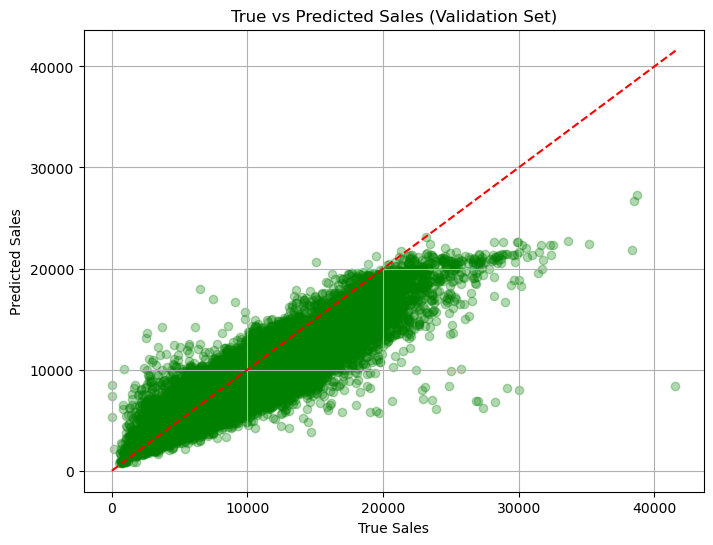

In [299]:
#Scatter Plot: True vs Predicted

plt.figure(figsize=(8,6))
plt.scatter(check_y_val, check_y_val_pred, alpha=0.3, color='green')
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")
plt.title("True vs Predicted Sales (Validation Set)")
plt.plot([check_y_val.min(), check_y_val.max()], [check_y_val.min(), check_y_val.max()], 'r--')  # line y=x
plt.grid()
plt.show()

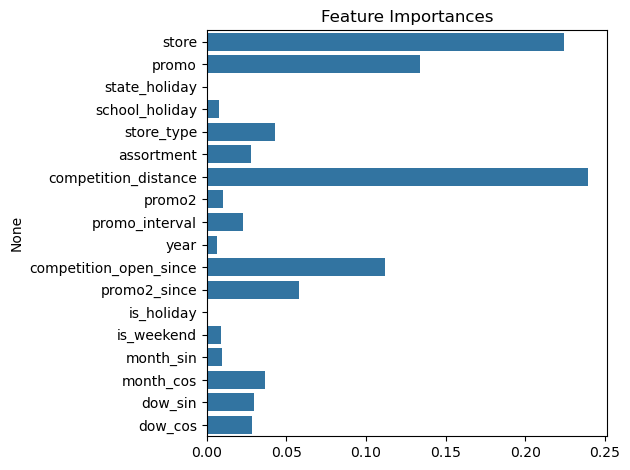

In [301]:
#Feature importance Check of best_model_rf_7

importances = best_model_rf_7.feature_importances_
features = check_X_train.columns

sns.barplot(x = importances, y = features)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

### The r2 of best_model_rf_7 is 0.78 which is low so let's eliminate features that are no important

In [304]:
#Removing features which are least important in the above graph: ('state_holiday', 'is_holiday')- using threshold method

feature_importance_series = pd.Series(best_model_rf_7.feature_importances_, index = features)
#feature_importance_series

# Sort importances in descending order
sorted_importances = feature_importance_series.sort_values(ascending=False)
#sorted_importances

# Set threshold (e.g., 1% importance)
threshold = 0.01

# Select features above the threshold
selected_features_rf = feature_importance_series[feature_importance_series > threshold].index.tolist()
selected_features_rf

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo2',
 'promo_interval',
 'competition_open_since',
 'promo2_since',
 'month_cos',
 'dow_sin',
 'dow_cos']

In [271]:
#Hyperparameter tuning the model using RandomizedSearchCV and TimeSeriesSplit- random_search_8 with selected_features_rf (model# 9)
#with (check_X_train, check_X_val)

param_dist = { 'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 20, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': [None,'sqrt', 'log2', 0.3, 0.5] #Use of auto here gave me the error below
             }

selected_features_rf = ['store','promo','store_type','assortment','competition_distance','promo2','promo_interval','competition_open_since',
 'promo2_since','month_cos','dow_sin','dow_cos']

tscv = TimeSeriesSplit(n_splits = 3)

rf = RandomForestRegressor(random_state = 42)

#RandomizedSearchCV for hyperparameter tuning

random_search_8 = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 20, cv = tscv, scoring = 'neg_mean_squared_error',
                                   verbose = 2, n_jobs = -1)

random_search_8.fit(check_X_train[selected_features_rf], check_y_train)

print("Best parameters: ", random_search_8.best_params_)
print("Best RMSE: ", (-random_search_8.best_score_) ** 0.5)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.5min
[CV] END max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=56.2min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.2min
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  32.0s
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.3s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; 

In [274]:
best_model_rf_8 = random_search_8.best_estimator_

#Prediction of Validation Set:
check_y_val_pred = best_model_rf_8.predict(check_X_val[selected_features_rf])

#Calculate performance metrics
mae = mean_absolute_error(check_y_val, check_y_val_pred)
rmse = mean_squared_error(check_y_val, check_y_val_pred, squared = False)
r2 = r2_score(check_y_val, check_y_val_pred)
rmspe_score = rmspe(check_y_val, check_y_val_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2: .4f}")
print(f"RMSPE: {rmspe_score: .4f}")


MAE: 1022.62
RMSE: 1511.50
R2 Score:  0.7566
RMSPE:  0.2125


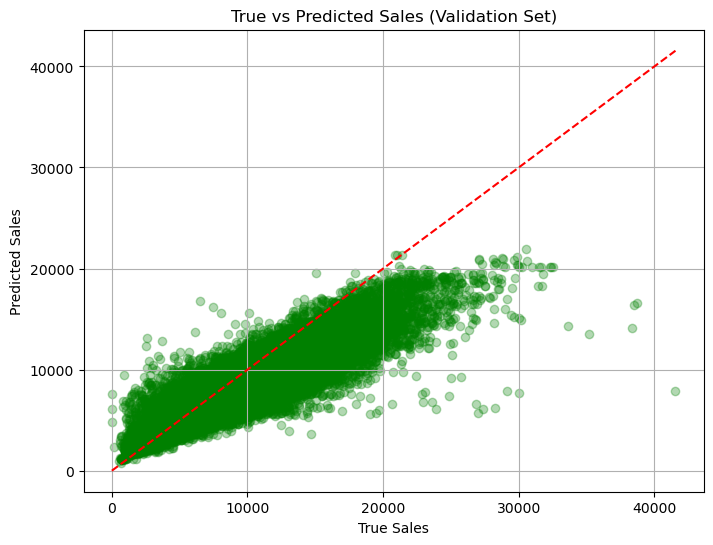

In [276]:
#Scatter Plot: True vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(check_y_val, check_y_val_pred, alpha=0.3, color='green')
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")
plt.title("True vs Predicted Sales (Validation Set)")
plt.plot([check_y_val.min(), check_y_val.max()], [check_y_val.min(), check_y_val.max()], 'r--')  # line y=x
plt.grid()
plt.show()

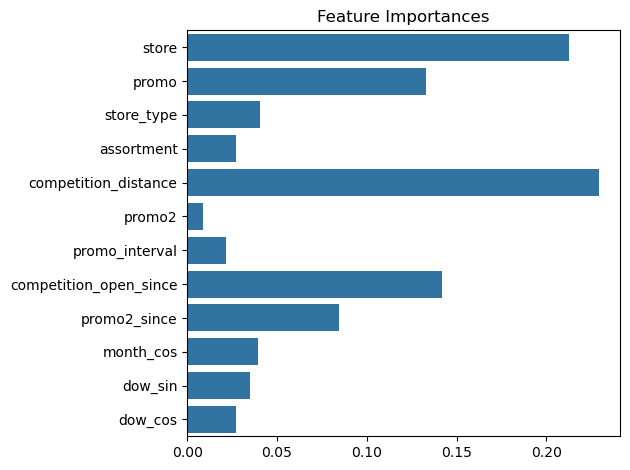

In [278]:
#Feature importance Check of best_model_rf_8

importances = best_model_rf_8.feature_importances_
features = selected_features_rf

sns.barplot(x = importances, y = features)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

### Best r2 score we have got using random forest model is 0.8185, let's use XGBoost model to see if there's an improvement in r2

### XGBOOST
#### Training the data on XGBoost model

In [237]:
#Training the check_X_train on XGBoost and hyperparameter tuning - random_search_xgb_2 model

param_grid = { 'n_estimators': [200, 300, 500],
              'max_depth': [6, 8, 10],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.7, 0.9, 1.0],
              'colsample_bytree': [0.7, 0.9, 1.0],
              'gamma': [0, 1, 5],
              'min_child_weight': [1, 5, 10]
             }
    
tscv = TimeSeriesSplit(n_splits = 3)

xgb = XGBRegressor(objective = 'reg:squarederror', random_state = 42, n_jobs = -1)

#RandomizedSearchCV for hyperparameter tuning

random_search_xgb_2 = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid, n_iter = 20, cv = tscv, 
                                         scoring = 'neg_mean_squared_error',verbose = 2, n_jobs = -1)

#Fit the model
random_search_xgb_2.fit(check_X_train, check_y_train)

print("Best parameters: ", random_search_xgb_2.best_params_)
print("Best RMSE: ", (-random_search_xgb_2.best_score_) ** 0.5)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters:  {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.7}
Best RMSE:  1621.6175005560387


In [280]:
best_model_xgb_2 = random_search_xgb_2.best_estimator_

#Prediction of Validation Set:
check_y_val_pred = best_model_xgb_2.predict(check_X_val)

#Calculate performance metrics
mae = mean_absolute_error(check_y_val, check_y_val_pred)
rmse = mean_squared_error(check_y_val, check_y_val_pred, squared = False)
r2 = r2_score(check_y_val, check_y_val_pred)
rmspe = rmspe(check_y_val, check_y_val_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2: .4f}")
print(f"RMSPE: {rmspe: .4f}")

MAE: 861.42
RMSE: 1256.37
R2 Score:  0.8318
RMSPE:  0.1929


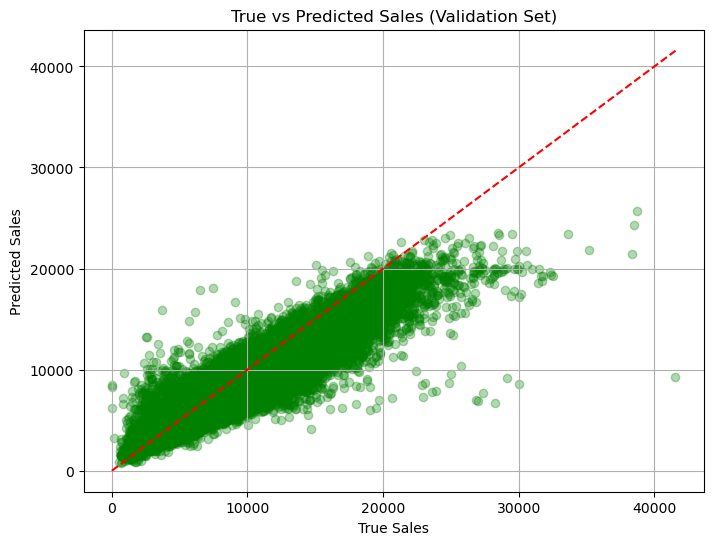

In [643]:
#Scatter Plot: True vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(check_y_val, check_y_val_pred, alpha=0.3, color='green')
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")
plt.title("True vs Predicted Sales (Validation Set)")
plt.plot([check_y_val.min(), check_y_val.max()], [check_y_val.min(), check_y_val.max()], 'r--')  # line y=x
plt.grid()
plt.show()

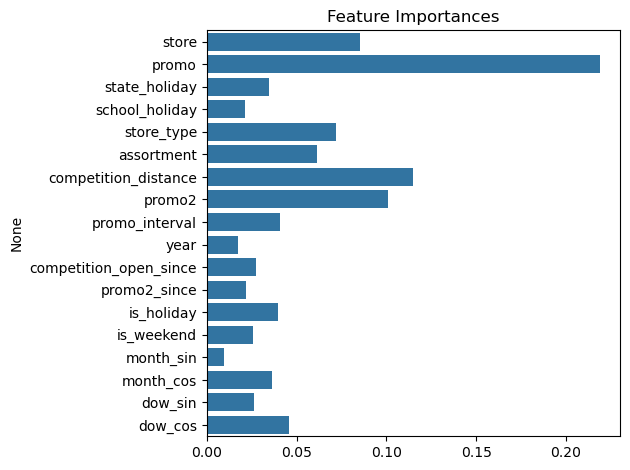

In [645]:
#Feature importance Check of best_model_xgb_2

importances = best_model_xgb_2.feature_importances_
features = check_X_train.columns

sns.barplot(x = importances, y = features)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

### Removing 'competiton_opne_since' and 'promo2_since' columns and training the data on XGBoost model

In [209]:
#Training the check_X_train on XGBoost and hyperparameter tuning - random_search_xgb_2_1 model without features (competition and promo2_since)

param_grid = { 'n_estimators': [200, 300, 500],
              'max_depth': [6, 8, 10],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.7, 0.9, 1.0],
              'colsample_bytree': [0.7, 0.9, 1.0],
              'gamma': [0, 1, 5],
              'min_child_weight': [1, 5, 10]
             }
    
tscv = TimeSeriesSplit(n_splits = 3)

features_no_timedelta = [col for col in check_X_train.columns if col not in ['competition_open_since', 'promo2_since']]

xgb = XGBRegressor(objective = 'reg:squarederror', random_state = 42, n_jobs = -1)

#RandomizedSearchCV for hyperparameter tuning

random_search_xgb_2_1 = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid, n_iter = 20, cv = tscv, 
                                         scoring = 'neg_mean_squared_error',verbose = 2, n_jobs = -1)

#Fit the model
random_search_xgb_2_1.fit(check_X_train[features_no_timedelta], check_y_train)

print("Best parameters: ", random_search_xgb_2_1.best_params_)
print("Best RMSE: ", (-random_search_xgb_2_1.best_score_) ** 0.5)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters:  {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.7}
Best RMSE:  1403.4615392911223


In [267]:
best_model_xgb_2_1 = random_search_xgb_2_1.best_estimator_

#Prediction of Validation Set:
check_y_val_pred = best_model_xgb_2_1.predict(check_X_val[features_no_timedelta])

#Calculate performance metrics
mae = mean_absolute_error(check_y_val, check_y_val_pred)
rmse = mean_squared_error(check_y_val, check_y_val_pred, squared = False)
r2 = r2_score(check_y_val, check_y_val_pred)
rmspe_score = rmspe(check_y_val, check_y_val_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2: .4f}")
print(f"RMSPE: {rmspe_score: .4f}")


MAE: 743.56
RMSE: 1094.49
R2 Score:  0.8724
RMSPE:  0.1597


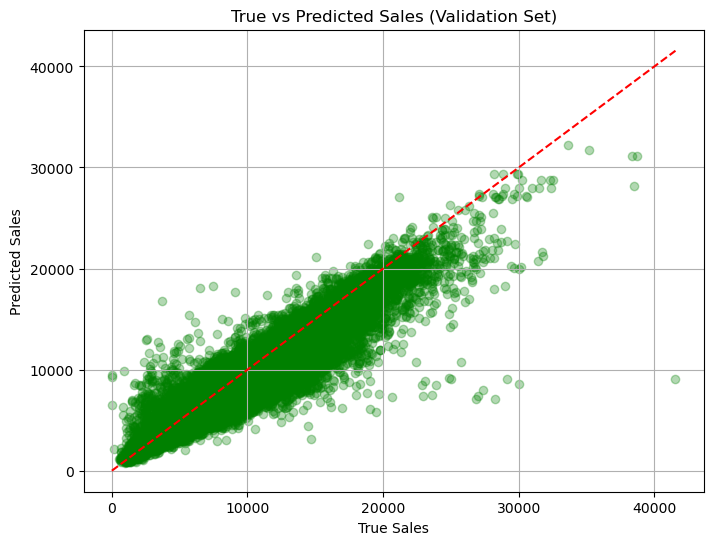

In [219]:
#Scatter Plot: True vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(check_y_val, check_y_val_pred, alpha=0.3, color='green')
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")
plt.title("True vs Predicted Sales (Validation Set)")
plt.plot([check_y_val.min(), check_y_val.max()], [check_y_val.min(), check_y_val.max()], 'r--')  # line y=x
plt.grid()
plt.show()

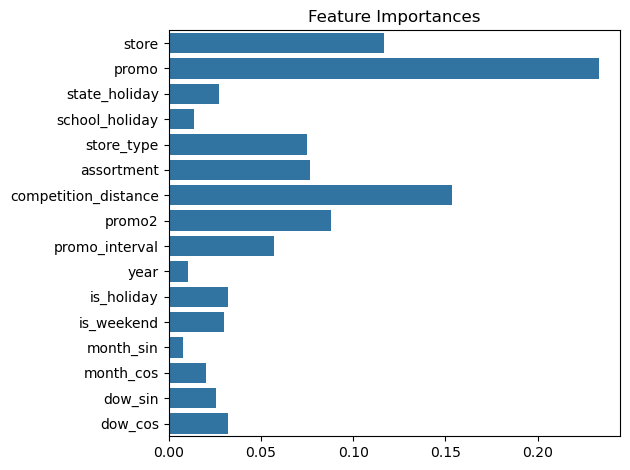

In [221]:
#Feature importance Check of best_model_xgb_2_1

importances = best_model_xgb_2_1.feature_importances_

features = features_no_timedelta

sns.barplot(x = importances, y = features)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

### We have got the best R2 Score of 0.8724 using the XGBoost model (best_model_xgb_2_1) we will use that for the prediction of sales in the test set

In [285]:
#Predicting the value of Sales in the test set using best_model_xgb_2_1 model
test_set_pred = best_model_xgb_2_1.predict(test_set[features_no_timedelta])
test_set_pred

array([5358.851 , 4891.519 , 5778.1074, ..., 9820.62  , 4788.348 ,
       4740.5786], dtype=float32)

### Conclusion:

In this project, I tackled the Rossmann Store Sales Forecasting problem using machine learning models, with a focus on time-aware feature engineering and validation. The goal was to predict daily sales across 1,115 stores based on historical data, promotions, holidays, and store attributes.

#### Feature Engineering:

Performed label encoding on categorical variables such as StoreType, Assortment, and StateHoliday to make them machine-readable.

Created time-aware features like:

CompetitionOpenSince — number of months since a competing store opened.

Promo2Since — number of months since a store started participating in Promo2.

Extracted date-based features like year, month from the Date column to capture temporal patterns.

#### Modeling:
Evaluated a range of regression models including Random Forest, and XGBoost. 

Among these XGBoost emerged as the best-performing model with:

R² Score: 0.8724 — explaining ~87% of the variance in sales.

RMSPE: 0.1597 — indicating only ~16% average percentage deviation from true sales values (after excluding days with zero sales).

Validation Strategy:
Used time-based train-validation split to mimic a realistic forecasting scenario, ensuring the model only had access to past data while validating on unseen future periods.

#### Interpretation of Results:
An R² > 0.85 on real-world sales data is a strong indicator that the model has successfully captured major patterns — such as weekly seasonality, promotional effects, and store-specific behaviors.

An RMSPE of ~16% suggests good predictive accuracy, especially considering the dataset’s diversity (many stores, regions, and external factors).

